In [1]:
import pandas as pd

### Setup and Preprocessing

In [6]:
# Set the path to your dataset 
csv_path = '../data/US_Accidents_March23.csv'

# Load full dataset
df = pd.read_csv(csv_path)



## 🧮 Risk Metrics Computation

In this analysis, we computed key **risk metrics** from the US Accidents dataset, focusing on accident frequency trends across states and years, stratified by severity and weather condition.

### ✅ Step-by-Step Summary

1. **Data Loading & Cleaning**
   - Read the full dataset with `parse_dates` to interpret `Start_Time` as datetime.
   - Dropped rows with missing values in critical columns (`Start_Time`, `State`, `Severity`, `Weather_Condition`).
   - Removed duplicate accident records using `ID`.
   - Extracted **Year** from `Start_Time` for annual analysis.

2. **Metric Computation**
   - **Total Accidents per State-Year**: Counted all incidents grouped by `Year` and `State`.
   - **Severity Breakdown**: Computed accident counts for each severity level (1–4) by year and state.
   - **Weather Condition Breakdown**: Filtered to top 5 most common weather conditions and counted their accidents per year and state.

3. **Output Saving**
   - Results were saved to the `outputs/metrics/` folder as:
     - `annual_state_accidents.csv`
     - `severity_breakdown.csv`
     - `weather_condition_breakdown.csv`

These metrics form the foundation for **risk analysis and visualizations**, enabling targeted insights into accident patterns by location, severity, and weather.


In [11]:
import pandas as pd

# === Step 1: Load and clean the dataset ===
def load_and_clean_data(csv_path):
    df = pd.read_csv(csv_path, parse_dates=['Start_Time'], low_memory=False)

    # Drop rows with missing critical columns
    df['Start_Time'] = pd.to_datetime(df['Start_Time'], errors='coerce')
    df = df[df['Start_Time'].notna()]
    df = df[df['State'].notna()]
    df = df[df['Severity'].isin([1, 2, 3, 4])]
    df = df[df['Weather_Condition'].notna()]

    # Remove duplicates
    df = df.drop_duplicates(subset='ID')

    # Extract year
    df['Year'] = df['Start_Time'].dt.year

    return df

# === Step 2: Compute Risk Metrics ===
def compute_risk_metrics(df):
    # Total accidents per state per year
    total_accidents = df.groupby(['Year', 'State']).size().reset_index(name='Total_Accidents')

    # By Severity
    severity_counts = df.groupby(['Year', 'State', 'Severity']).size().unstack(fill_value=0).reset_index()
    severity_counts.columns.name = None

    # By Weather Condition (top 5 conditions only for readability)
    top_conditions = df['Weather_Condition'].value_counts().head(5).index.tolist()
    filtered_df = df[df['Weather_Condition'].isin(top_conditions)]
    weather_counts = filtered_df.groupby(['Year', 'State', 'Weather_Condition']).size().unstack(fill_value=0).reset_index()
    weather_counts.columns.name = None

    return total_accidents, severity_counts, weather_counts

# === Step 3: Save the results to CSVs for analysis/plotting ===
def save_outputs(total_accidents, severity_counts, weather_counts, out_dir='outputs/metrics'):
    import os
    os.makedirs(out_dir, exist_ok=True)
    total_accidents.to_csv(f'{out_dir}/annual_state_accidents.csv', index=False)
    severity_counts.to_csv(f'{out_dir}/severity_breakdown.csv', index=False)
    weather_counts.to_csv(f'{out_dir}/weather_condition_breakdown.csv', index=False)

# === Master Runner ===
def main():
    csv_path = '../data/US_Accidents_March23.csv'  # update path as needed
    df_clean = load_and_clean_data(csv_path)

    total_accidents, severity_counts, weather_counts = compute_risk_metrics(df_clean)

    save_outputs(total_accidents, severity_counts, weather_counts)

    return total_accidents.head(), severity_counts.head(), weather_counts.head()

# Run main function and show sample output
main()


(   Year State  Total_Accidents
 0  2016    AL              132
 1  2016    AR               26
 2  2016    AZ             2735
 3  2016    CA           138226
 4  2016    CO             1320,
    Year State   1      2      3     4
 0  2016    AL   0     72     24    36
 1  2016    AR   0     17      4     5
 2  2016    AZ   0   1927    352   456
 3  2016    CA  96  85601  51347  1182
 4  2016    CO   0    700    214   406,
    Year State  Clear  Cloudy  Fair  Mostly Cloudy  Partly Cloudy
 0  2016    AL     68       0     1             10             21
 1  2016    AR     16       0     2              5              2
 2  2016    AZ   1330       1     7            412            430
 3  2016    CA  80281     201  1515          12171          12475
 4  2016    CO    437       9     4            266            195)

**Observations:** States like California reported significantly higher accident counts compared to others in 2016, with California alone recording over 138,000 accidents. Severity breakdown shows that most incidents are of moderate severity (levels 2 and 3), with high-severity (level 4) cases forming a small but crucial portion. Clear weather dominates reported conditions, yet substantial numbers of accidents also occur under "Partly Cloudy" and "Mostly Cloudy" skies, suggesting that even mildly adverse weather can impact driving safety.


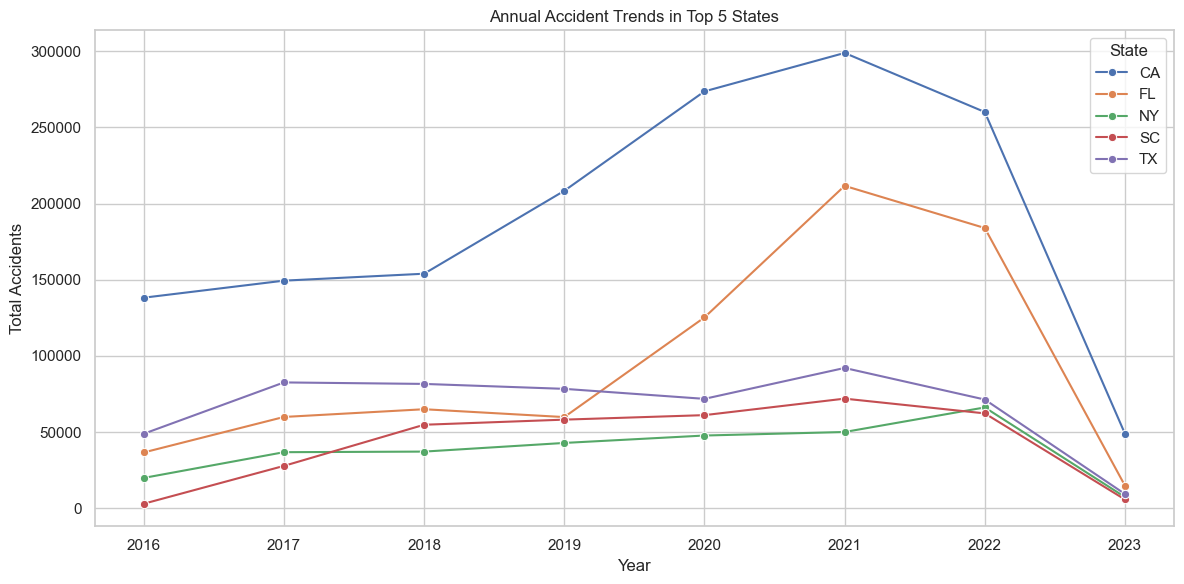

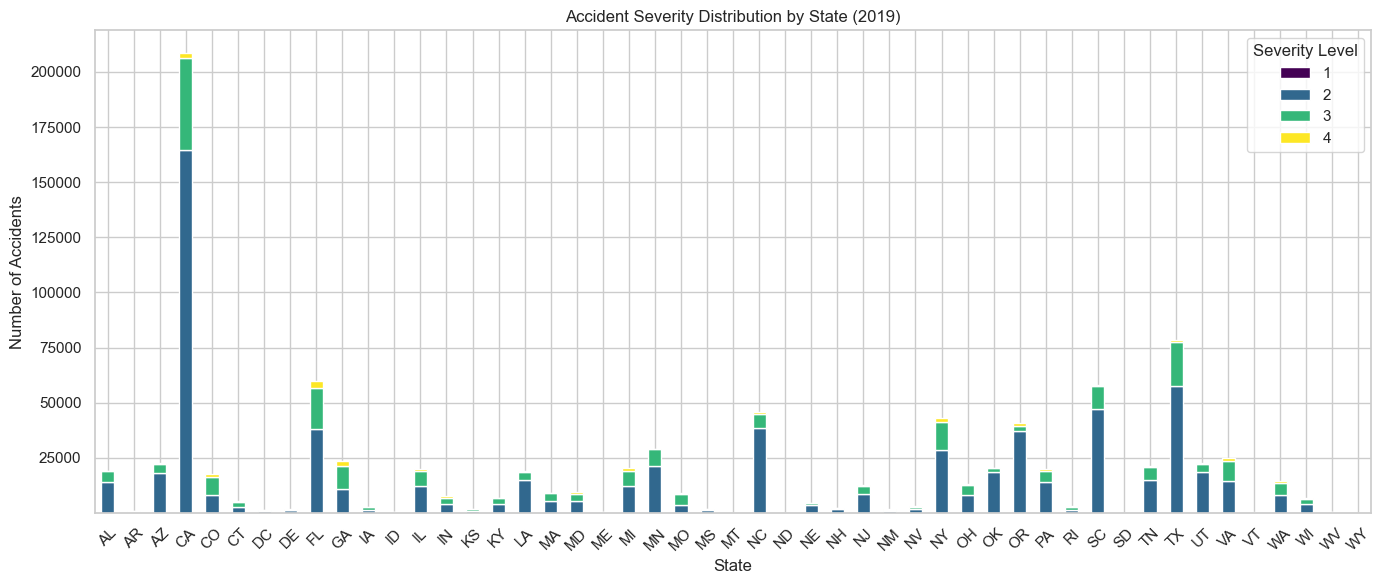

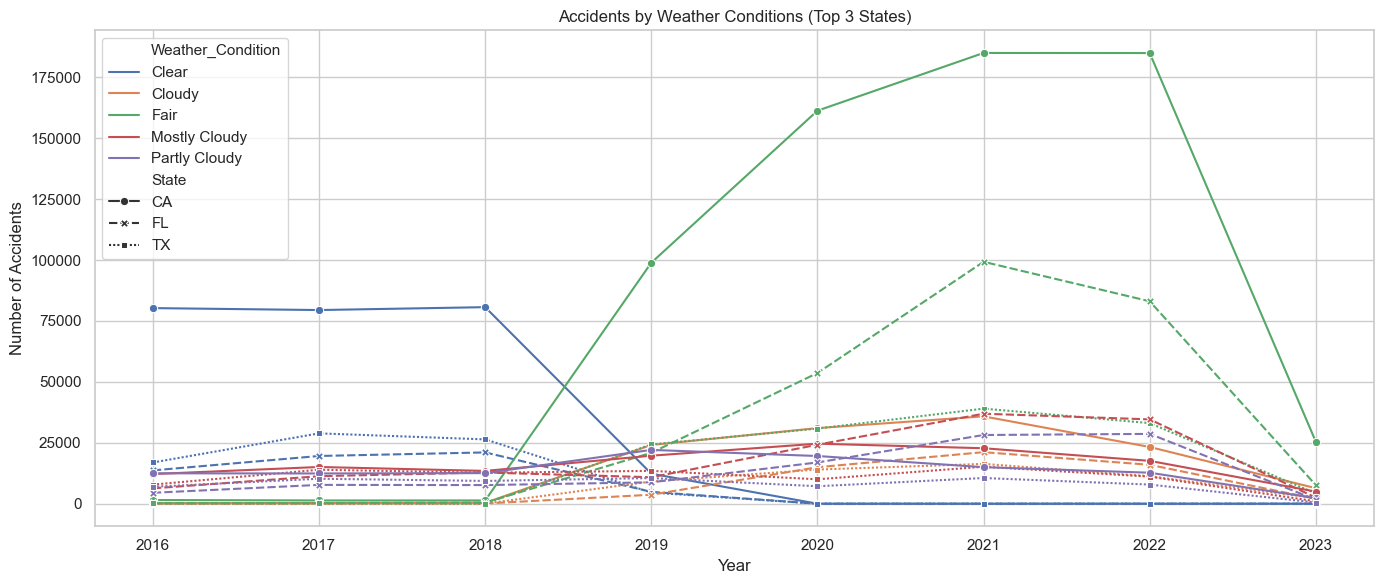

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# === Step 0: Create output folder for figures ===
os.makedirs('outputs/figures', exist_ok=True)

# === Load Saved CSVs ===
total_accidents = pd.read_csv('outputs/metrics/annual_state_accidents.csv')
severity_breakdown = pd.read_csv('outputs/metrics/severity_breakdown.csv')
weather_breakdown = pd.read_csv('outputs/metrics/weather_condition_breakdown.csv')

# === Total Accidents Over Time for Top States ===
top_states = total_accidents.groupby('State')['Total_Accidents'].sum().nlargest(5).index.tolist()
plot_df = total_accidents[total_accidents['State'].isin(top_states)]

plt.figure(figsize=(12, 6))
sns.lineplot(data=plot_df, x='Year', y='Total_Accidents', hue='State', marker='o')
plt.title('Annual Accident Trends in Top 5 States')
plt.ylabel('Total Accidents')
plt.grid(True)
plt.tight_layout()
plt.savefig('outputs/figures/total_accidents_top_states.png')
plt.show()

# === Severity Breakdown (Stacked Bar for Sample Year) ===
sample_year = 2019
severity_sample = severity_breakdown[severity_breakdown['Year'] == sample_year].set_index('State')
severity_sample = severity_sample[[str(i) for i in range(1, 5) if str(i) in severity_sample.columns]]

severity_sample.plot(kind='bar', stacked=True, figsize=(14, 6), colormap='viridis')
plt.title(f'Accident Severity Distribution by State ({sample_year})')
plt.xlabel('State')
plt.ylabel('Number of Accidents')
plt.xticks(rotation=45)
plt.legend(title='Severity Level')
plt.tight_layout()
plt.savefig('outputs/figures/severity_distribution_2019.png')
plt.show()

# === Weather Condition Breakdown for Top 3 States ===
weather_long = weather_breakdown.melt(id_vars=['Year', 'State'], var_name='Weather_Condition', value_name='Accident_Count')
weather_top_states = weather_breakdown.groupby('State').sum(numeric_only=True).sum(axis=1).nlargest(3).index.tolist()
weather_plot_df = weather_long[weather_long['State'].isin(weather_top_states)]

plt.figure(figsize=(14, 6))
sns.lineplot(data=weather_plot_df, x='Year', y='Accident_Count', hue='Weather_Condition', style='State', markers=True)
plt.title('Accidents by Weather Conditions (Top 3 States)')
plt.ylabel('Number of Accidents')
plt.grid(True)
plt.tight_layout()
plt.savefig('outputs/figures/weather_conditions_top3_states.png')
plt.show()


**Observations:** 
* **Annual accident trends in top 5 states:** California and Florida consistently report the highest number of annual traffic accidents, with sharp increases between 2019 and 2021. All five top states exhibit a sudden and dramatic drop in 2023, suggesting either reporting lag, intervention effects, or data availability issues. This pattern warrants further investigation into systemic changes or disruptions post-2022. One plausible reason could be the **post-pandemic shift to remote or hybrid work significantly reduced commuting traffic, especially in high-density urban states like CA, TX, and NY**. This would naturally lower traffic volume and thus accident counts, particularly during morning and evening peak hours.

* **Severity distribution 2019:** This stacked bar plot shows the distribution of accident severity across U.S. states in 2019. States like **California, Florida, and Texas** experienced the **highest accident volumes**, predominantly of **Severity Level 2, with noticeable contributions from higher severity** levels as well. In contrast, many other states show much lower volumes and minimal presence of high-severity accidents, highlighting stark regional disparities in both accident frequency and seriousness.

* **Accidents by Weather conditions:** This line plot illustrates accident trends under various weather conditions for California, Florida, and Texas from 2016 to 2023. Across all three states, **fair, clear and partly cloudy conditions** consistently contributed to the highest number of accidents, likely reflecting typical weather patterns where most driving occurs. Notably, California shows a dramatic drop in accidents post-2019 under clear weather, but spike for fair weather condition, while Florida and Texas saw spikes around 2021, particularly under fair and mostly cloudy conditions.


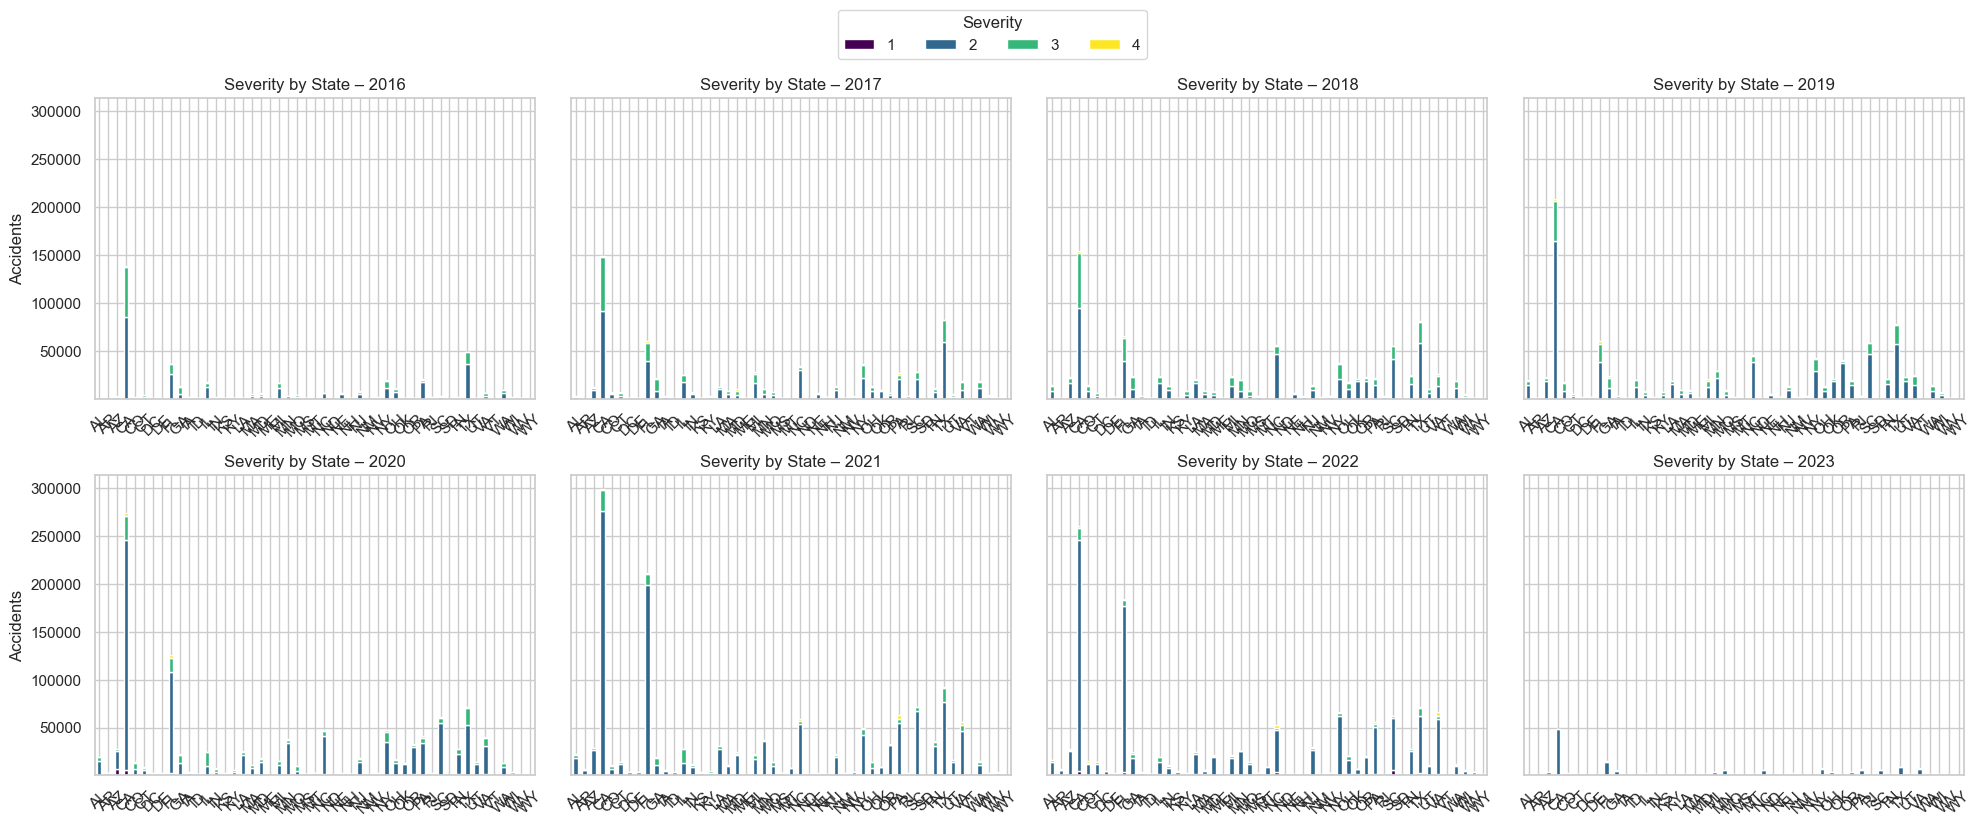

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Load the data
severity_breakdown = pd.read_csv('outputs/metrics/severity_breakdown.csv')

# Use string columns for severity
severity_cols = [col for col in severity_breakdown.columns if col in ['1', '2', '3', '4']]

# Define year range
years = sorted(severity_breakdown['Year'].unique())
n_cols = 4
n_rows = (len(years) + n_cols - 1) // n_cols

# Set up output path
os.makedirs('outputs/figures', exist_ok=True)

# Plot subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows), sharey=True)
axes = axes.flatten()

for idx, year in enumerate(years):
    ax = axes[idx]
    df_year = severity_breakdown[severity_breakdown['Year'] == year].set_index('State')
    df_year = df_year[[col for col in severity_cols if col in df_year.columns]]
    df_year.plot(kind='bar', stacked=True, ax=ax, colormap='viridis', legend=False)
    ax.set_title(f'Severity by State – {year}')
    ax.set_xlabel('')
    ax.set_ylabel('Accidents')
    ax.tick_params(axis='x', labelrotation=45)

# Hide unused subplots
for i in range(len(years), len(axes)):
    fig.delaxes(axes[i])

# Shared legend
fig.legend(title='Severity', labels=['1', '2', '3', '4'], loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.04))
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.savefig('outputs/figures/severity_by_state_all_years.png')
plt.show()


**Observations:** This grid of stacked bar plots shows accident severity distribution across all U.S. states from 2016 to 2023. **California consistently leads in total accident counts**, dominated by Severity 2 incidents. A **notable drop is observed in 2023 across all states**, possibly due to data incompleteness, while states like Texas and Florida show **more balanced distributions of Severity 2 and 3 accidents** over the years, indicating moderate to severe incident prevalence.

### Annual count of accidents by U.S. state and time of day 

In this task, we computed the **annual count of accidents by U.S. state and time of day (Morning, Afternoon, Evening, Night)** using the Start_Time column to extract hourly patterns. The result was stored in a structured matrix (`accidents_by_time_of_day.csv`), allowing us to visualize accident density across different times of day and states. A heatmap for the most recent year highlights when and where accidents are most concentrated, offering insights into temporal risk distribution.

In [51]:
%matplotlib inline


def compute_and_plot_time_of_day_risk(df, out_dir='outputs/metrics/time_of_day'):
    import os
    import matplotlib.pyplot as plt
    import seaborn as sns

    os.makedirs(out_dir, exist_ok=True)

    # Ensure datetime conversion
    df['Start_Time'] = pd.to_datetime(df['Start_Time'], errors='coerce')
    df = df[df['Start_Time'].notna()]  # Drop rows with invalid dates

    # Define time of day
    def categorize_hour(hour):
        if 5 <= hour < 12:
            return 'Morning'
        elif 12 <= hour < 17:
            return 'Afternoon'
        elif 17 <= hour < 21:
            return 'Evening'
        else:
            return 'Night'

    # Create Time_of_Day column
    df['Hour'] = df['Start_Time'].dt.hour
    df['Time_of_Day'] = df['Hour'].apply(categorize_hour)

    # Group and save
    tod_counts = df.groupby(['Year', 'State', 'Time_of_Day']).size().reset_index(name='Accident_Count')
    tod_counts.to_csv(f'{out_dir}/accidents_by_time_of_day.csv', index=False)

    # Plot for latest year
    latest_year = df['Year'].max()
    plot_df = tod_counts[tod_counts['Year'] == latest_year].pivot(index='State', columns='Time_of_Day', values='Accident_Count').fillna(0)

    plt.figure(figsize=(10, 12))
    sns.heatmap(plot_df, cmap='coolwarm', linewidths=0.5, annot=True, fmt='.0f')
    plt.title(f'Accidents by Time of Day and State – {latest_year}')
    plt.xlabel('Time of Day')
    plt.ylabel('State')
    plt.tight_layout()
    plt.savefig(f'{out_dir}/accidents_by_time_of_day_{latest_year}.png')
    plt.show()


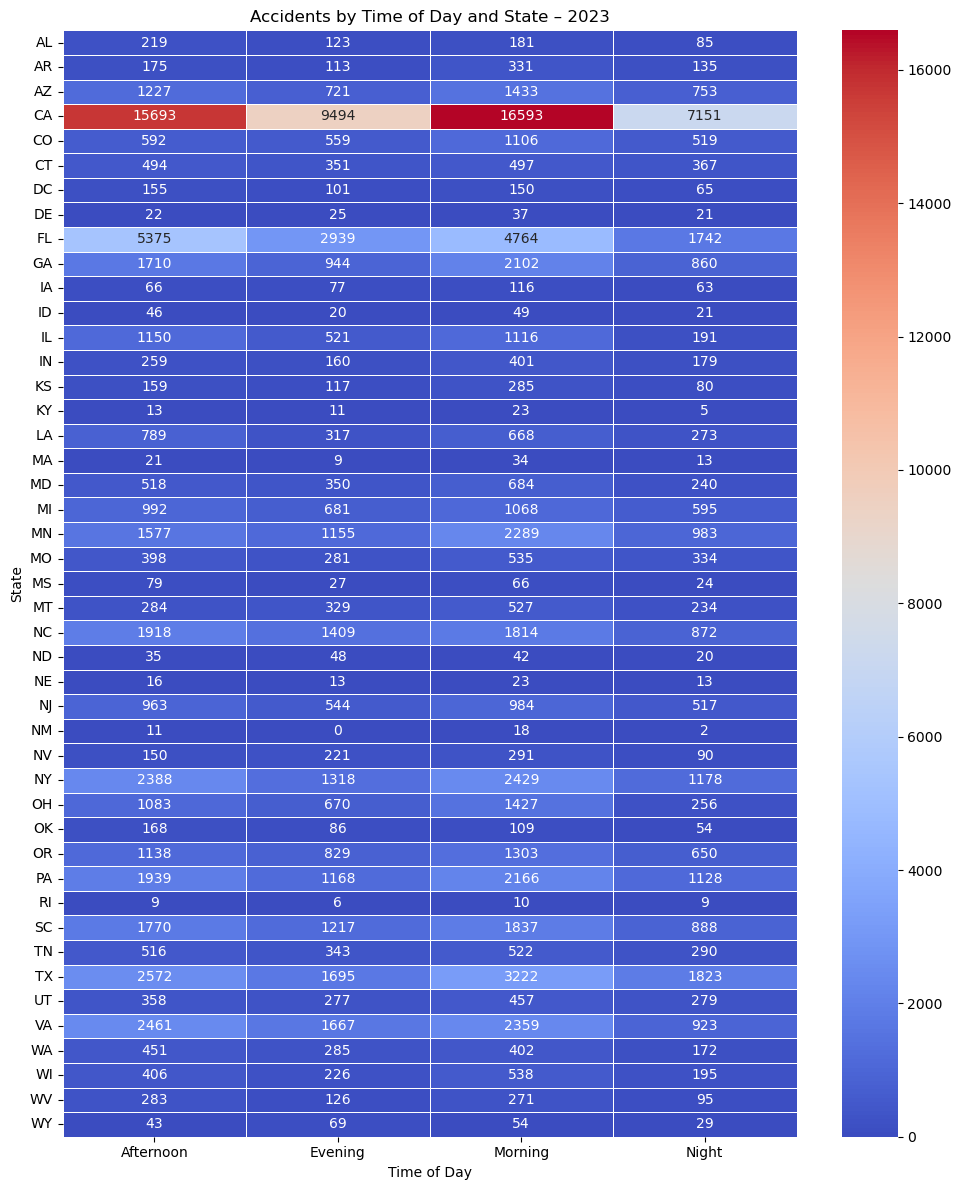

In [16]:
df_clean = load_and_clean_data(csv_path)
compute_and_plot_time_of_day_risk(df_clean)


**Observations:** This heatmap shows the distribution of accidents across different times of day and states in 2023. **Morning and afternoon periods see the highest accident counts**, particularly in high-population states like **California, Texas, Florida, and New York**, indicating strong **commuting-related risk patterns**. Visualizing additional years could be valuable to assess whether these time-of-day trends are consistent over time or impacted by policy, seasonal, or societal changes (e.g., post-pandemic shifts).

In [52]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

def plot_time_of_day_heatmap(df, year, out_dir):
    year_df = df[df['Year'] == year]
    pivot_df = year_df.pivot(index='State', columns='Time_of_Day', values='Accident_Count').fillna(0)

    plt.figure(figsize=(10, 12))
    sns.heatmap(pivot_df, cmap='coolwarm', linewidths=0.5, annot=True, fmt='.0f')
    plt.title(f'Accidents by Time of Day and State – {year}')
    plt.xlabel('Time of Day')
    plt.ylabel('State')
    plt.tight_layout()

    os.makedirs(out_dir, exist_ok=True)
    plt.savefig(f'{out_dir}/accidents_by_time_of_day_{year}.png')
    plt.close()

# === Load and plot for selected years ===
df = pd.read_csv('outputs/metrics/time_of_day/accidents_by_time_of_day.csv')
selected_years = [2016, 2020, 2023]

for year in selected_years:
    plot_time_of_day_heatmap(df, year, 'outputs/metrics/time_of_day')


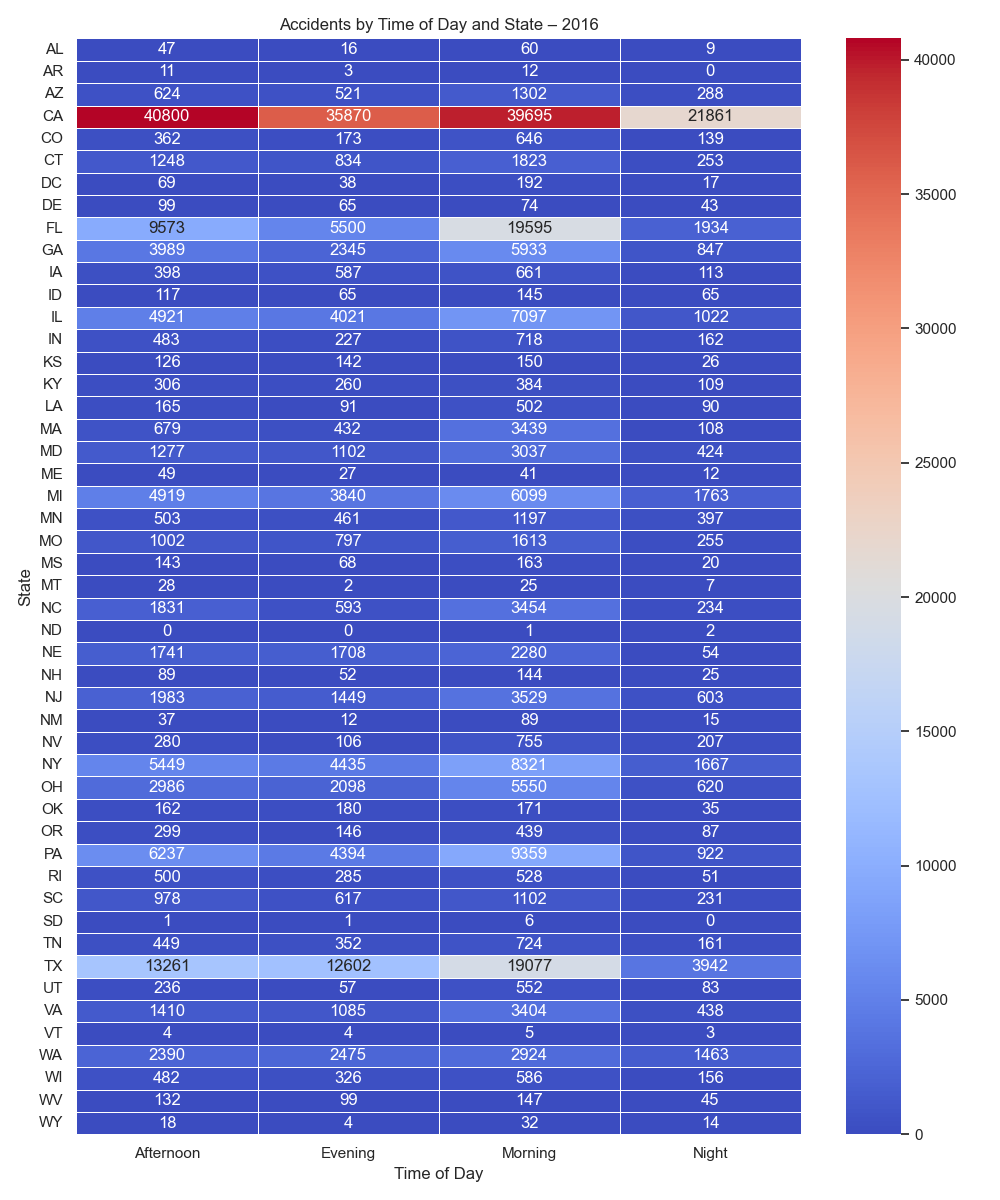

In [55]:
from IPython.display import Image, display
display(Image('outputs/metrics/time_of_day/accidents_by_time_of_day_2016.png'))



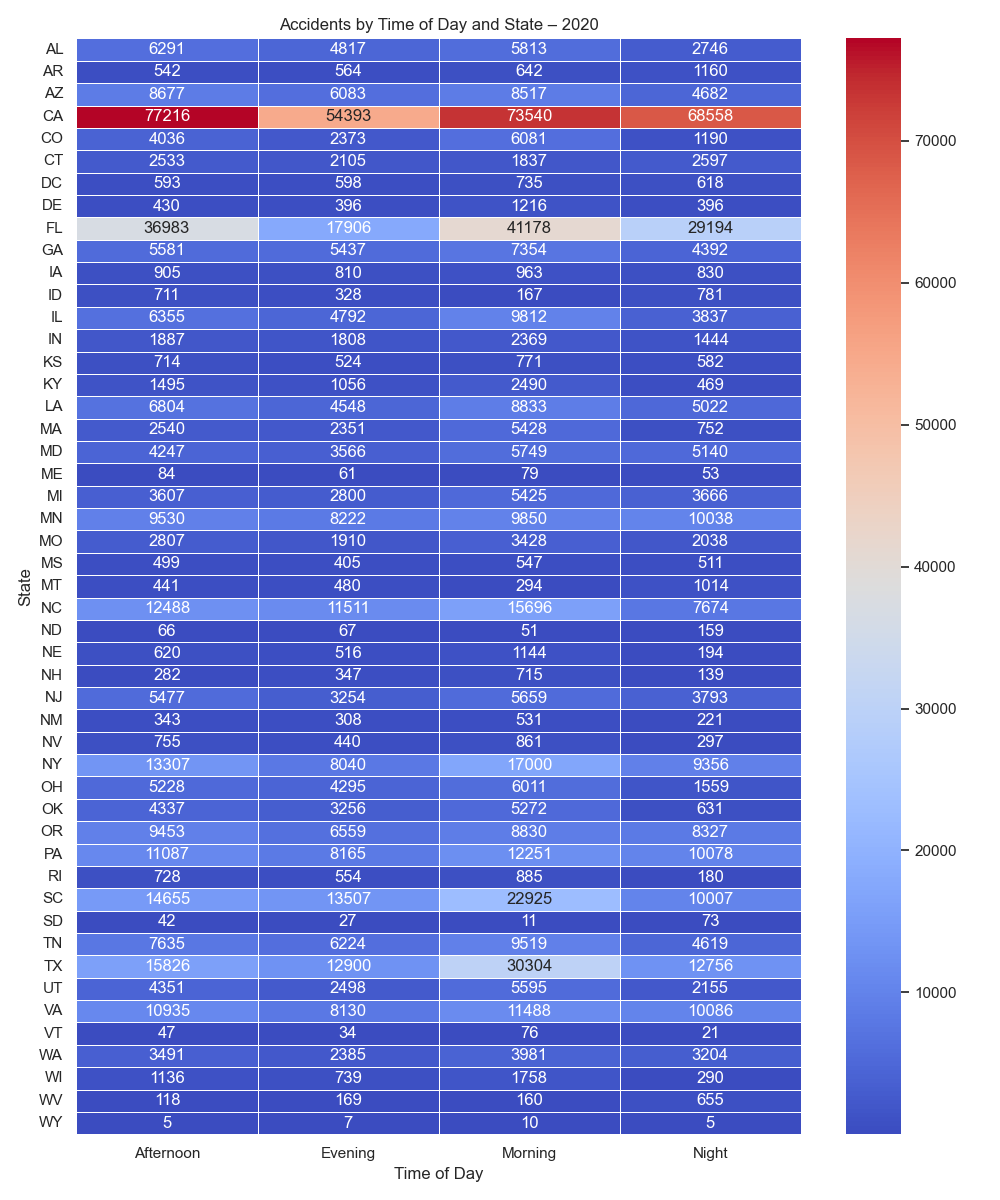

In [56]:
display(Image('outputs/metrics/time_of_day/accidents_by_time_of_day_2020.png'))

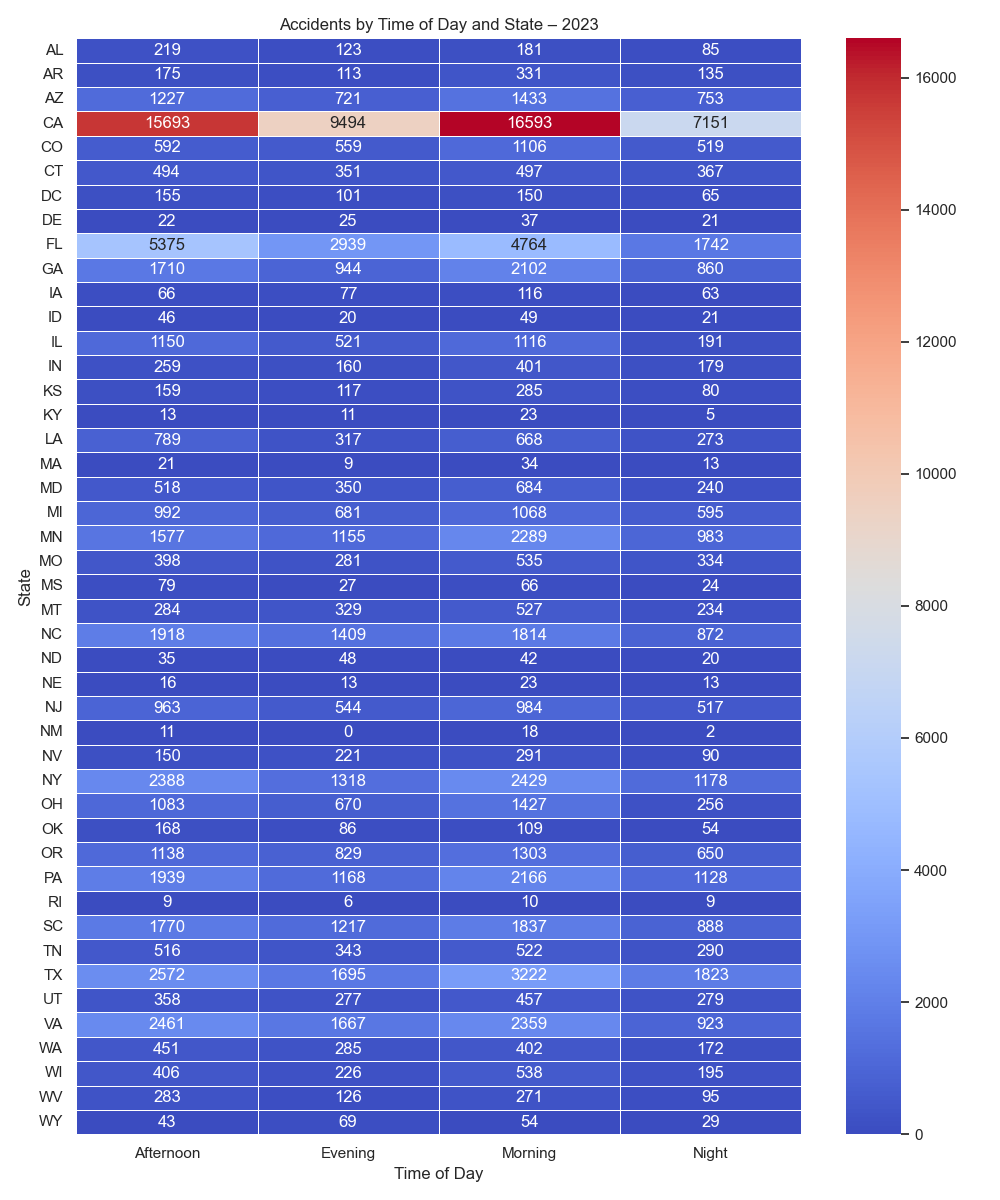

In [57]:
display(Image('outputs/metrics/time_of_day/accidents_by_time_of_day_2023.png'))

**Observations:** **Accident Trends by Time of Day – Comparative Insights (2016, 2020, 2023)**

Across all three years, a consistent pattern emerges: **Morning and Afternoon** hours witness the highest accident counts in most states, likely corresponding to peak commuting periods.

However, the **total volume of accidents** varies dramatically by year:

* **2020** shows the highest accident counts across nearly all states and times of day, particularly in states like **CA, FL, TX**, despite pandemic lockdowns in early months. This may reflect a shift in road behavior or data artifacts.

* **2016** also reports relatively high accident counts, especially during morning commutes in large states.

* **2023**, in contrast, exhibits a **notable decline** in accident volumes overall. While the temporal trend (morning/afternoon peaks) remains, the intensity is much lower. This could result from:

Incomplete data reporting for the year

Post-pandemic work-from-home practices reducing road traffic

Improved traffic safety measures or behavioral changes

The trend highlights the importance of **not just when accidents happen**, but also how broader societal shifts (like the pandemic) may affect public risk levels.



### Accidents by Time of Day and Severity (Year-wise)

This visualization shows how accident frequency varies across different times of day, stratified by severity level, for each year.

In [20]:
def plot_severity_by_time_of_day(df, out_dir='outputs/metrics/time_of_day'):
    import os
    import matplotlib.pyplot as plt
    import seaborn as sns

    os.makedirs(out_dir, exist_ok=True)

    # Ensure Start_Time is datetime
    df['Start_Time'] = pd.to_datetime(df['Start_Time'], errors='coerce')
    df = df[df['Start_Time'].notna()]

    # Add derived columns safely
    df['Year'] = df['Start_Time'].dt.year
    df.loc[:, 'Hour'] = df['Start_Time'].dt.hour

    def categorize_hour(hour):
        if 5 <= hour < 12:
            return 'Morning'
        elif 12 <= hour < 17:
            return 'Afternoon'
        elif 17 <= hour < 21:
            return 'Evening'
        else:
            return 'Night'

    df.loc[:, 'Time_of_Day'] = df['Hour'].apply(categorize_hour)

    # Group by Year, Time_of_Day, Severity
    grouped = df.groupby(['Year', 'Time_of_Day', 'Severity']).size().reset_index(name='Accident_Count')

    # Plot for each year
    for year in sorted(grouped['Year'].unique()):
        plt.figure(figsize=(10, 6))
        year_df = grouped[grouped['Year'] == year]
        sns.barplot(data=year_df, x='Time_of_Day', y='Accident_Count', hue='Severity')
        plt.title(f'Accidents by Time of Day and Severity – {year}')
        plt.xlabel('Time of Day')
        plt.ylabel('Number of Accidents')
        plt.legend(title='Severity')
        plt.tight_layout()
        plt.savefig(f'{out_dir}/accidents_by_time_of_day_severity_{year}.png')
        plt.show()


/var/folders/gw/b7p_041n59l085x02_97z5nm0000gp/T/ipykernel_20730/83790214.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Year'] = df['Start_Time'].dt.year
/var/folders/gw/b7p_041n59l085x02_97z5nm0000gp/T/ipykernel_20730/83790214.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'Hour'] = df['Start_Time'].dt.hour
/var/folders/gw/b7p_041n59l085x02_97z5nm0000gp/T/ipykernel_20730/83790214.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Tr

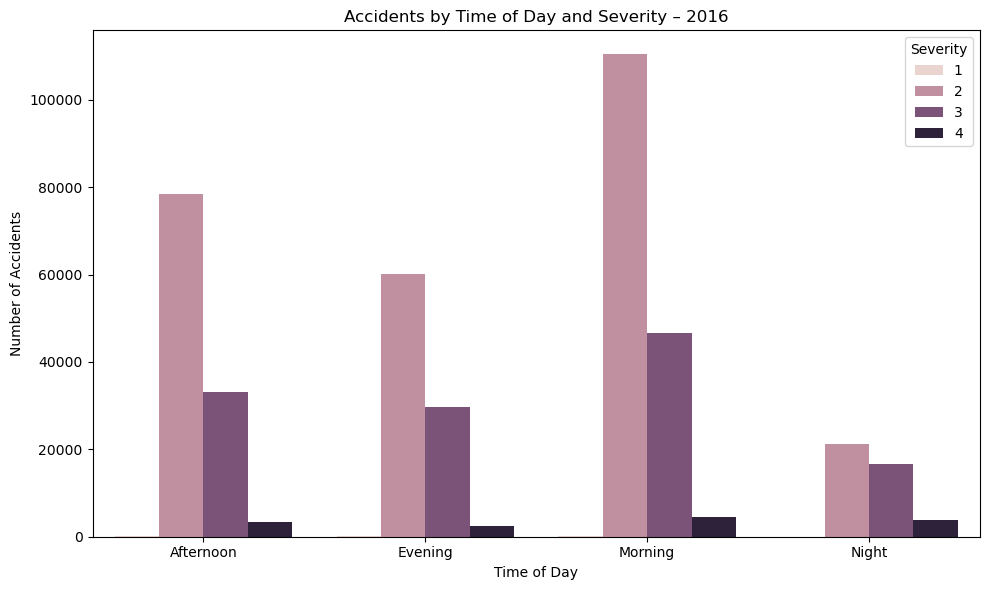

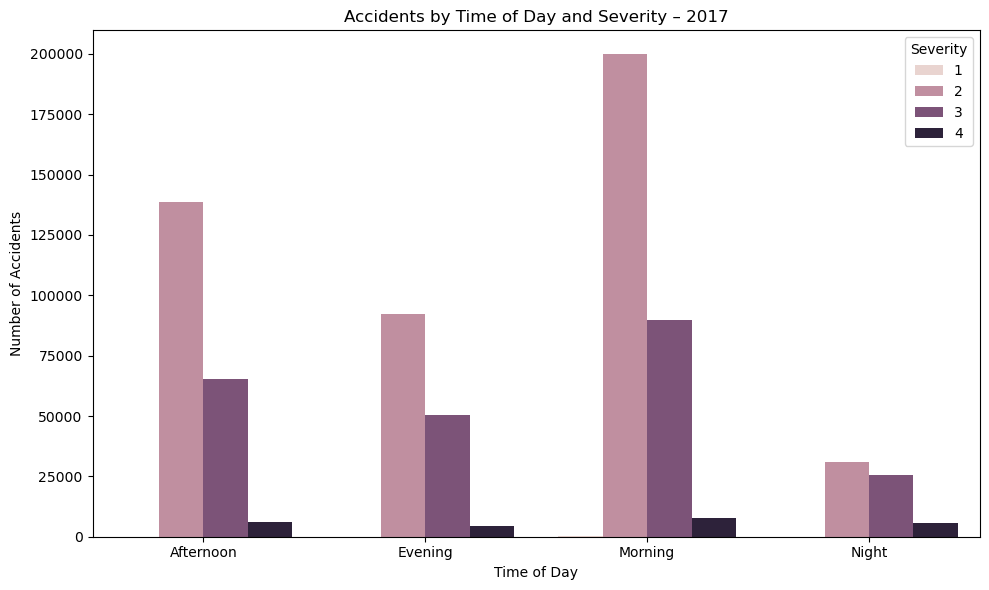

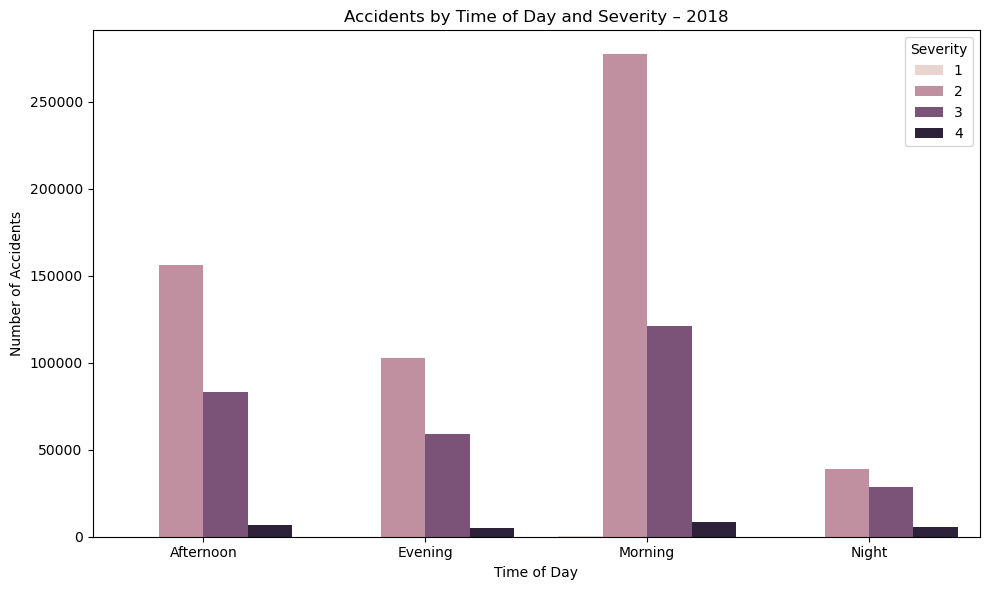

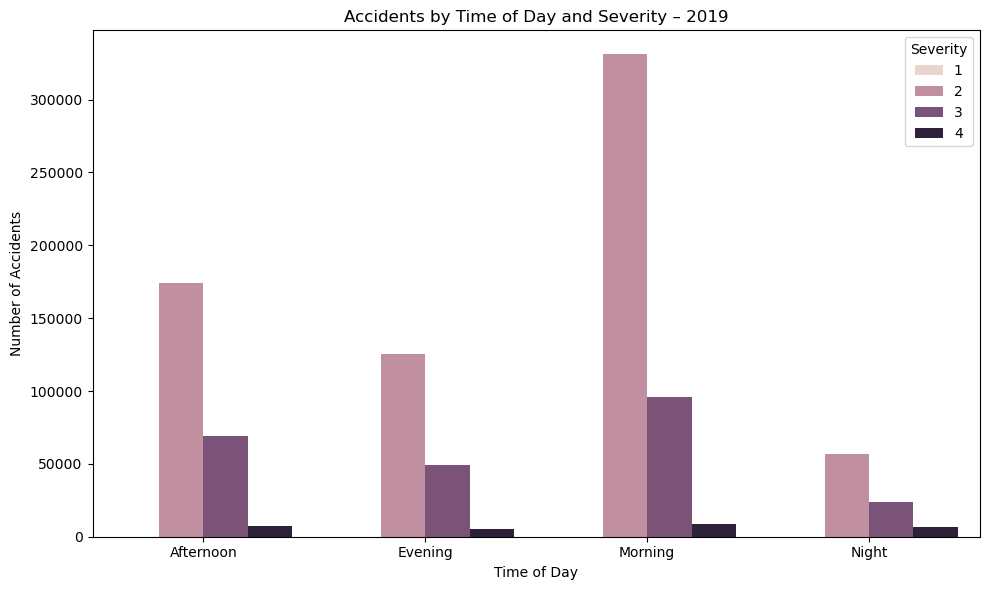

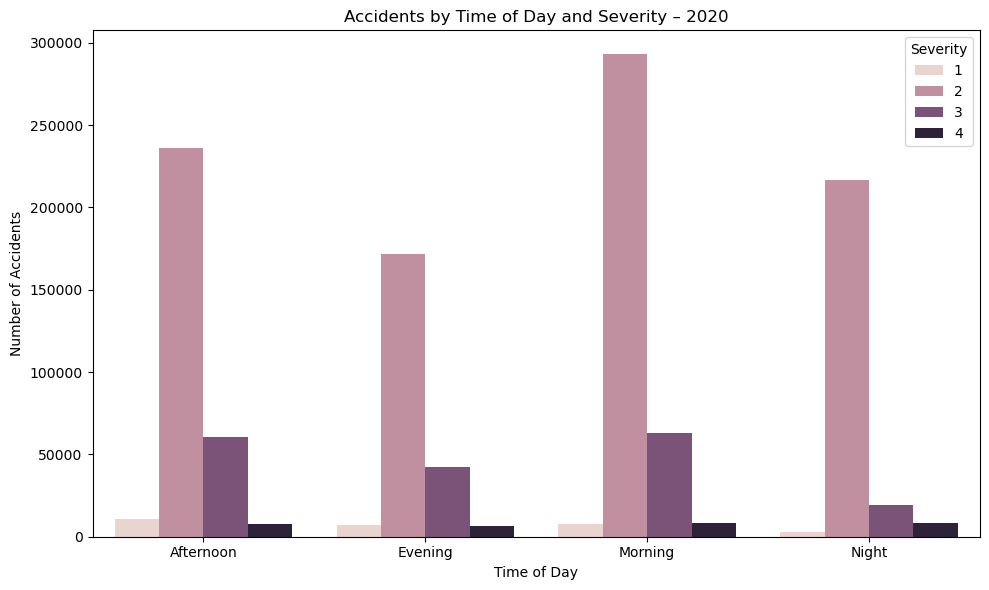

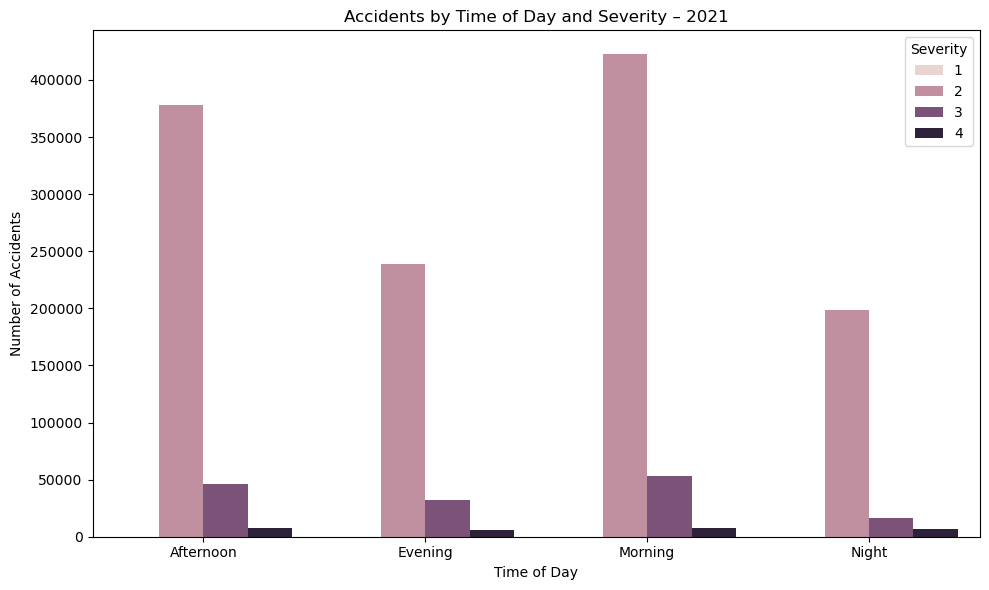

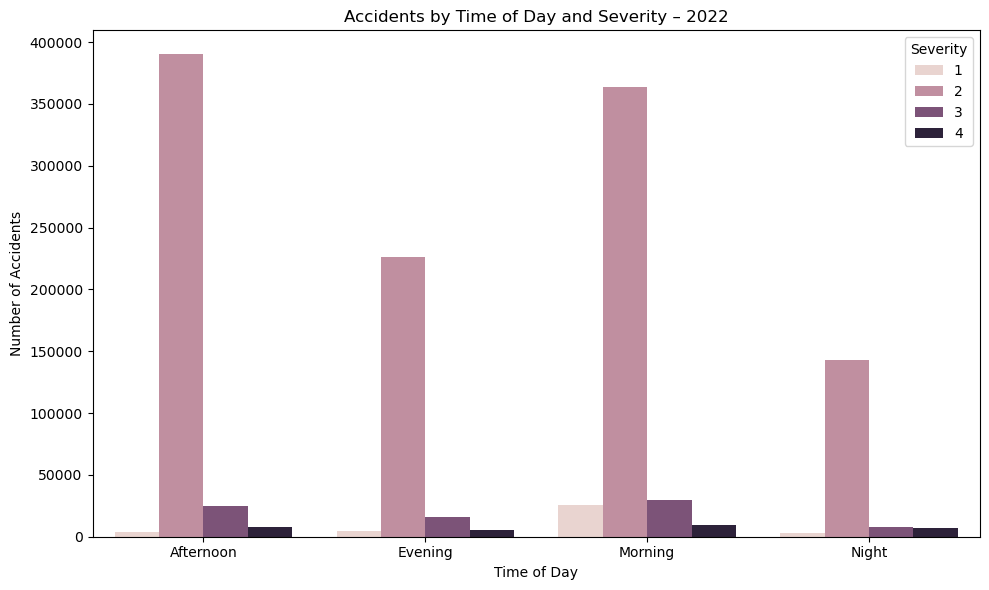

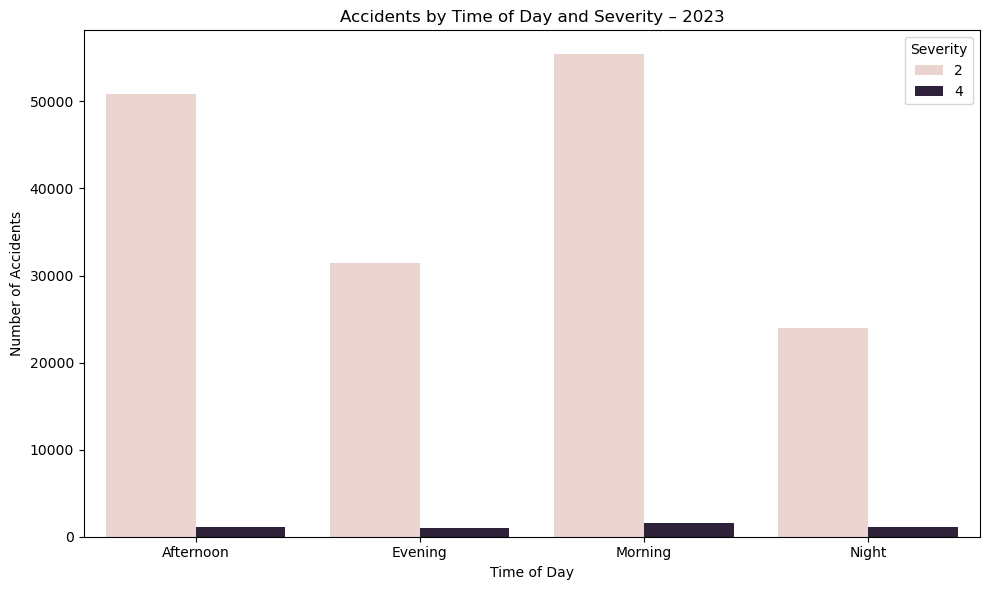

In [21]:
plot_severity_by_time_of_day(df)


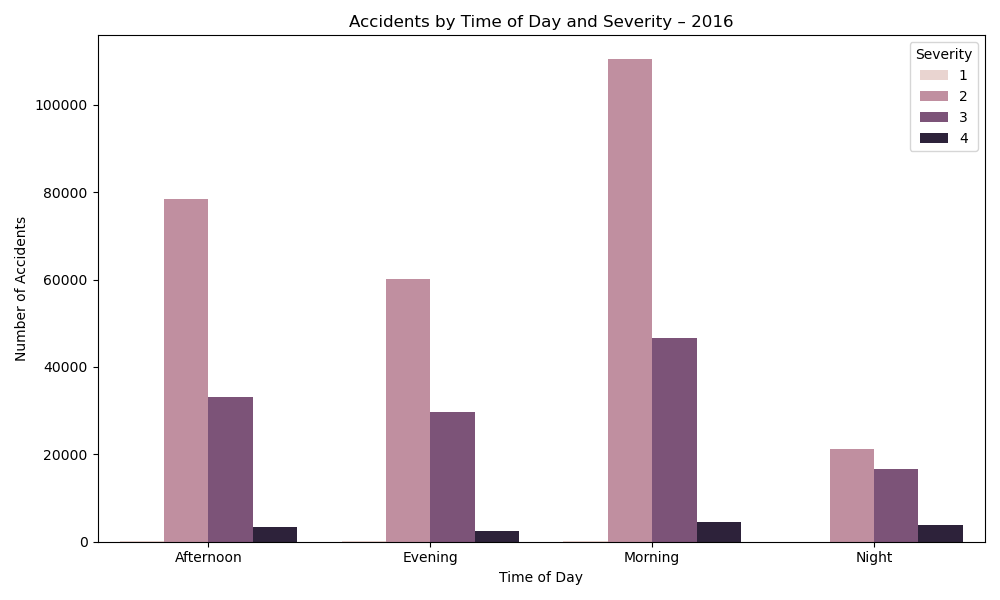

In [23]:
from IPython.display import Image, display
display(Image('outputs/metrics/time_of_day/accidents_by_time_of_day_severity_2016.png'))


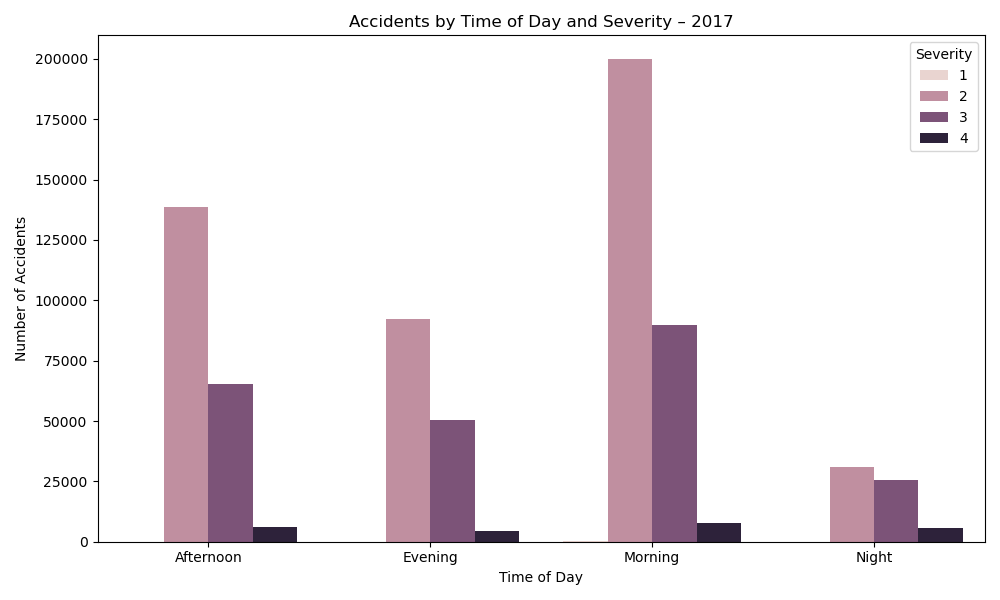

In [24]:
display(Image('outputs/metrics/time_of_day/accidents_by_time_of_day_severity_2017.png'))


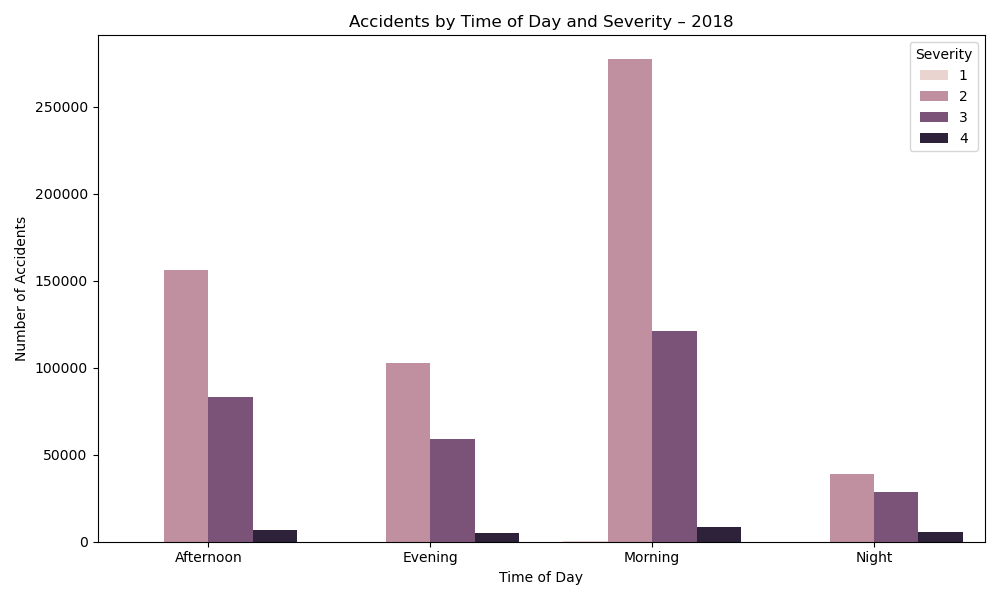

In [25]:
display(Image('outputs/metrics/time_of_day/accidents_by_time_of_day_severity_2018.png'))


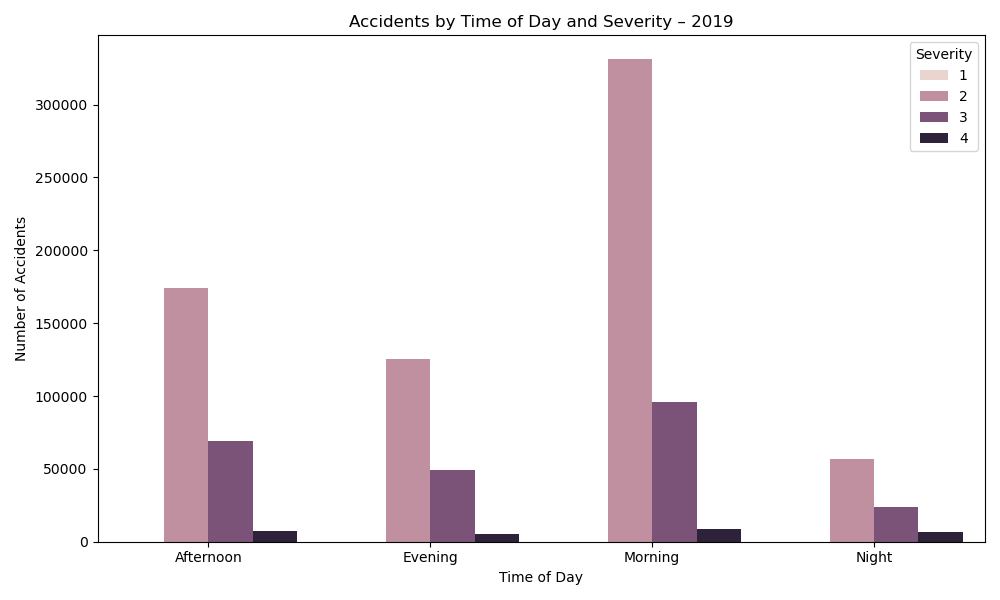

In [26]:
display(Image('outputs/metrics/time_of_day/accidents_by_time_of_day_severity_2019.png'))


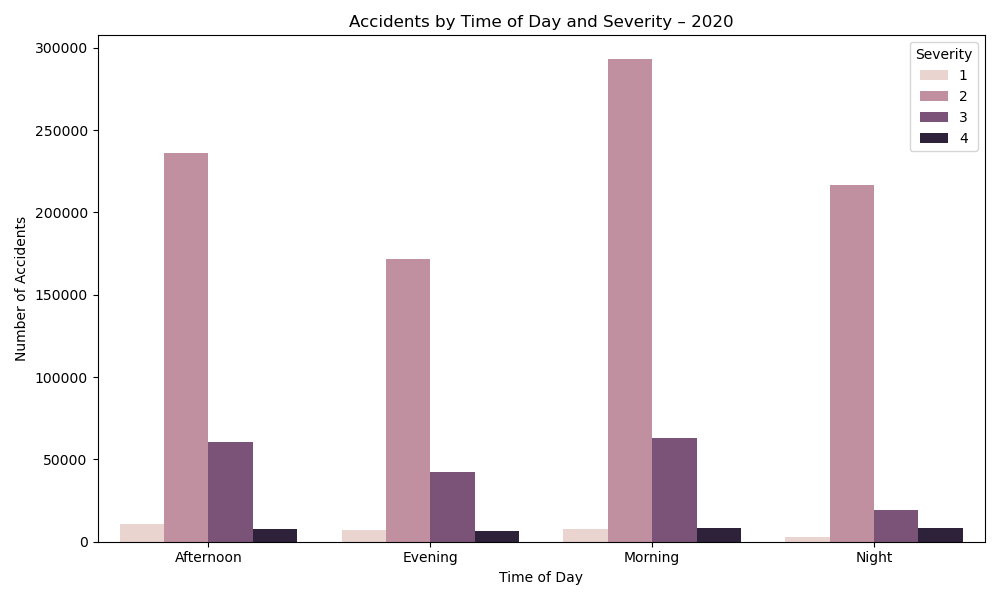

In [27]:
display(Image('outputs/metrics/time_of_day/accidents_by_time_of_day_severity_2020.png'))


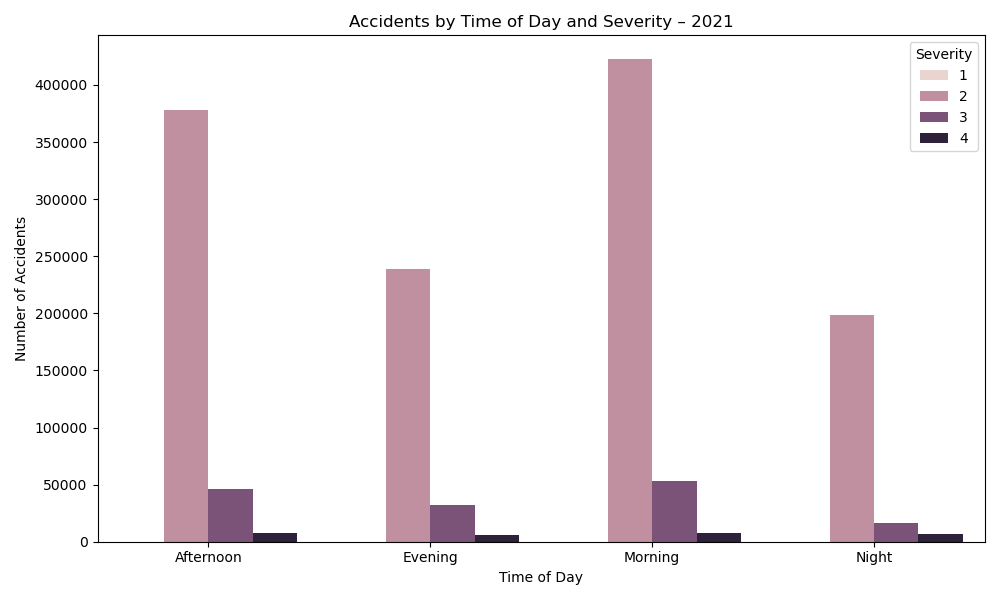

In [28]:
display(Image('outputs/metrics/time_of_day/accidents_by_time_of_day_severity_2021.png'))


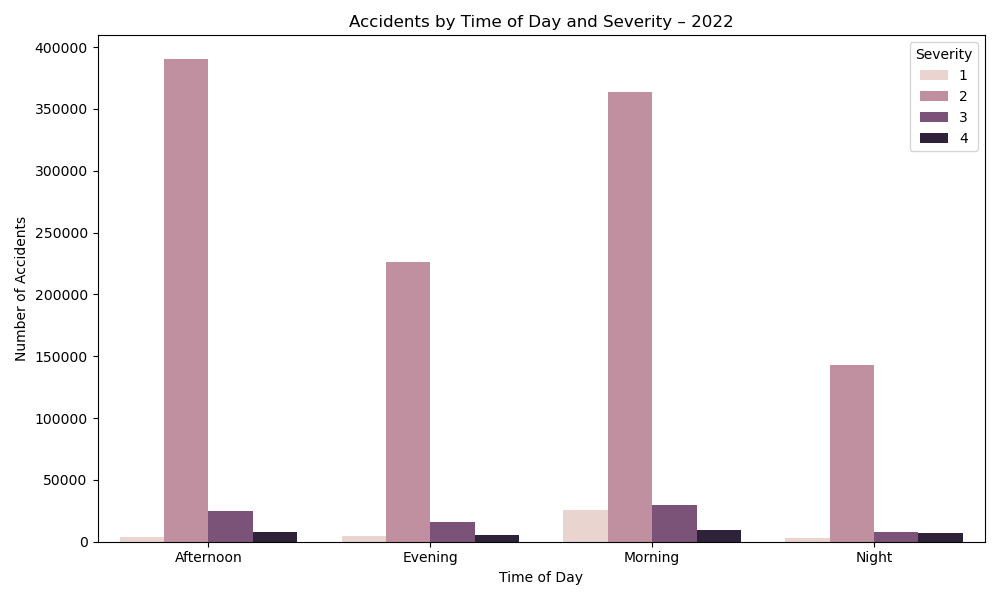

In [29]:
display(Image('outputs/metrics/time_of_day/accidents_by_time_of_day_severity_2022.png'))


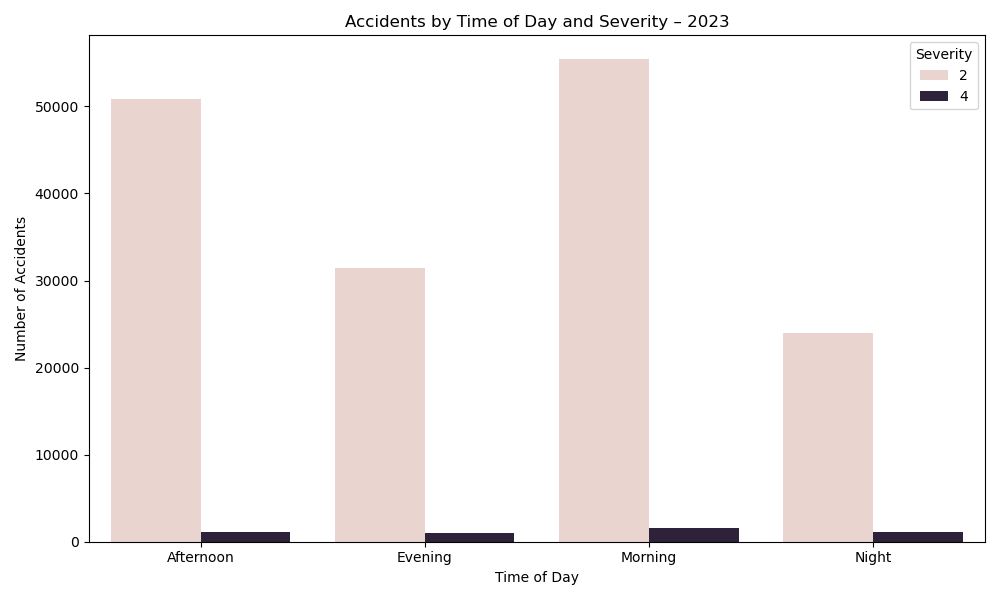

In [30]:
display(Image('outputs/metrics/time_of_day/accidents_by_time_of_day_severity_2023.png'))


### **Observations:**  
Across most years, Morning and Afternoon consistently exhibit the highest accident counts, with Severity 2 and 3 being the most common. The plots also reveal that while severe accidents (Severity 4) are relatively rarer, their distribution over time mirrors the general trend, highlighting morning and afternoon hours as critical risk periods.Surprisingly, for 2023, there are only accidents of severity 2 or 4, may be due to incomplete / missing datatsets.

In [32]:
import pandas as pd
import os

# === Step 1: Define population estimates ===
# Population in thousands (example estimates, adjust if needed)
population_data = {
    'CA': [39145, 39250, 39368, 39461, 39512, 39538, 39577, 39600],
    'TX': [27469, 27862, 28200, 28700, 29000, 29100, 29300, 29500],
    'FL': [20278, 20612, 20950, 21300, 21500, 21700, 21900, 22000],
    'NY': [19796, 19849, 19800, 19750, 19600, 19500, 19400, 19300]
}

years = list(range(2016, 2024))  # 2016 to 2023

# === Step 2: Build rows for DataFrame ===
rows = []
for state, pops in population_data.items():
    for year, pop in zip(years, pops):
        rows.append({'State': state, 'Year': year, 'Population': pop * 1000})  # Convert to individuals

# === Step 3: Save to CSV ===
df_pop = pd.DataFrame(rows)

os.makedirs('data', exist_ok=True)
df_pop.to_csv('data/state_population.csv', index=False)

print("Saved population estimates to data/state_population.csv")


✅ Saved population estimates to data/state_population.csv


### Advanced Risk Metrics: Normalized Rates and Severity Scoring

In this section, we go beyond raw accident counts to compute more insightful **risk metrics**:

**Accident Rate per 100,000 People**: Normalizes total accidents by state population to allow fair comparisons across states of different sizes.

**Severity-Weighted Score**: Assigns higher weights to more severe accidents and calculates a state-level severity score over time.

**Heatmaps**: We visualize both metrics using heatmaps to identify high-risk states and how risk levels have evolved annually.

These metrics provide a deeper understanding of public safety risks and help identify areas needing intervention beyond what raw counts can show.

📌 Note: Population estimates used in this analysis are approximate and based on publicly available sources. For policy or production use, consider replacing with official census data from the U.S. Census Bureau.


In [59]:
# advanced_risk_metrics.py
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# === Step 1: Load Risk Data and State Population ===
def load_data(accidents_path, population_path):
    accidents_df = pd.read_csv(accidents_path)
    population_df = pd.read_csv(population_path)
    return accidents_df, population_df

# === Step 2: Compute Accident Rate per 100,000 People ===
def compute_accident_rate(accidents_df, population_df):
    merged_df = pd.merge(accidents_df, population_df, on=['State', 'Year'], how='left')
    merged_df['Accident_Rate'] = merged_df['Total_Accidents'] / merged_df['Population'] * 100000
    return merged_df

# === Step 3: Compute Severity-Weighted Score ===
def compute_weighted_severity(df):
    severity_weights = {1: 1, 2: 2, 3: 4, 4: 5}
    df['Weight'] = df['Severity'].map(severity_weights)

    # Multiply weight by count to get total severity score
    df['Weighted_Severity'] = df['Weight'] * df['Count']

    # Compute weighted average: sum(weighted) / sum(count)
    weighted_df = df.groupby(['State', 'Year']).agg({
        'Weighted_Severity': 'sum',
        'Count': 'sum'
    }).reset_index()

    weighted_df['Weighted_Severity_Score'] = weighted_df['Weighted_Severity'] / weighted_df['Count']
    return weighted_df[['State', 'Year', 'Weighted_Severity_Score']]


# === Step 4: Plot Heatmaps ===
def plot_heatmap(df, value_col, out_path):
    pivot = df.pivot_table(index='State', columns='Year', values=value_col)
    plt.figure(figsize=(14, 10))
    sns.heatmap(pivot, cmap='YlOrRd', annot=True, fmt='.1f')
    plt.title(f'Heatmap of {value_col.replace("_", " ")} by State and Year')
    plt.tight_layout()
    plt.savefig(out_path)
    plt.close()

# === Step 5: Run All ===
def main():
    accidents_path = 'outputs/metrics/annual_state_accidents.csv'
    population_path = 'data/state_population.csv'  # You need to prepare this CSV
    out_dir = 'outputs/risk_metrics'
    os.makedirs(out_dir, exist_ok=True)

    accidents_df, population_df = load_data(accidents_path, population_path)
    rate_df = compute_accident_rate(accidents_df, population_df)
    rate_df.to_csv(f'{out_dir}/accident_rate_per_100k.csv', index=False)

    # Plot heatmap for normalized rate
    plot_heatmap(rate_df, 'Accident_Rate', f'{out_dir}/heatmap_accident_rate.png')

    # Load severity-level data to compute weighted severity
    severity_df = pd.read_csv('outputs/metrics/severity_breakdown.csv')
    severity_df = severity_df.melt(id_vars=['Year', 'State'], var_name='Severity', value_name='Count')
    severity_df['Severity'] = severity_df['Severity'].astype(int)

    weighted_df = compute_weighted_severity(severity_df)
    weighted_df.to_csv(f'{out_dir}/severity_weighted_score.csv', index=False)

    plot_heatmap(weighted_df, 'Weighted_Severity_Score', f'{out_dir}/heatmap_weighted_severity.png')

if __name__ == '__main__':
    main()


In [60]:
main()


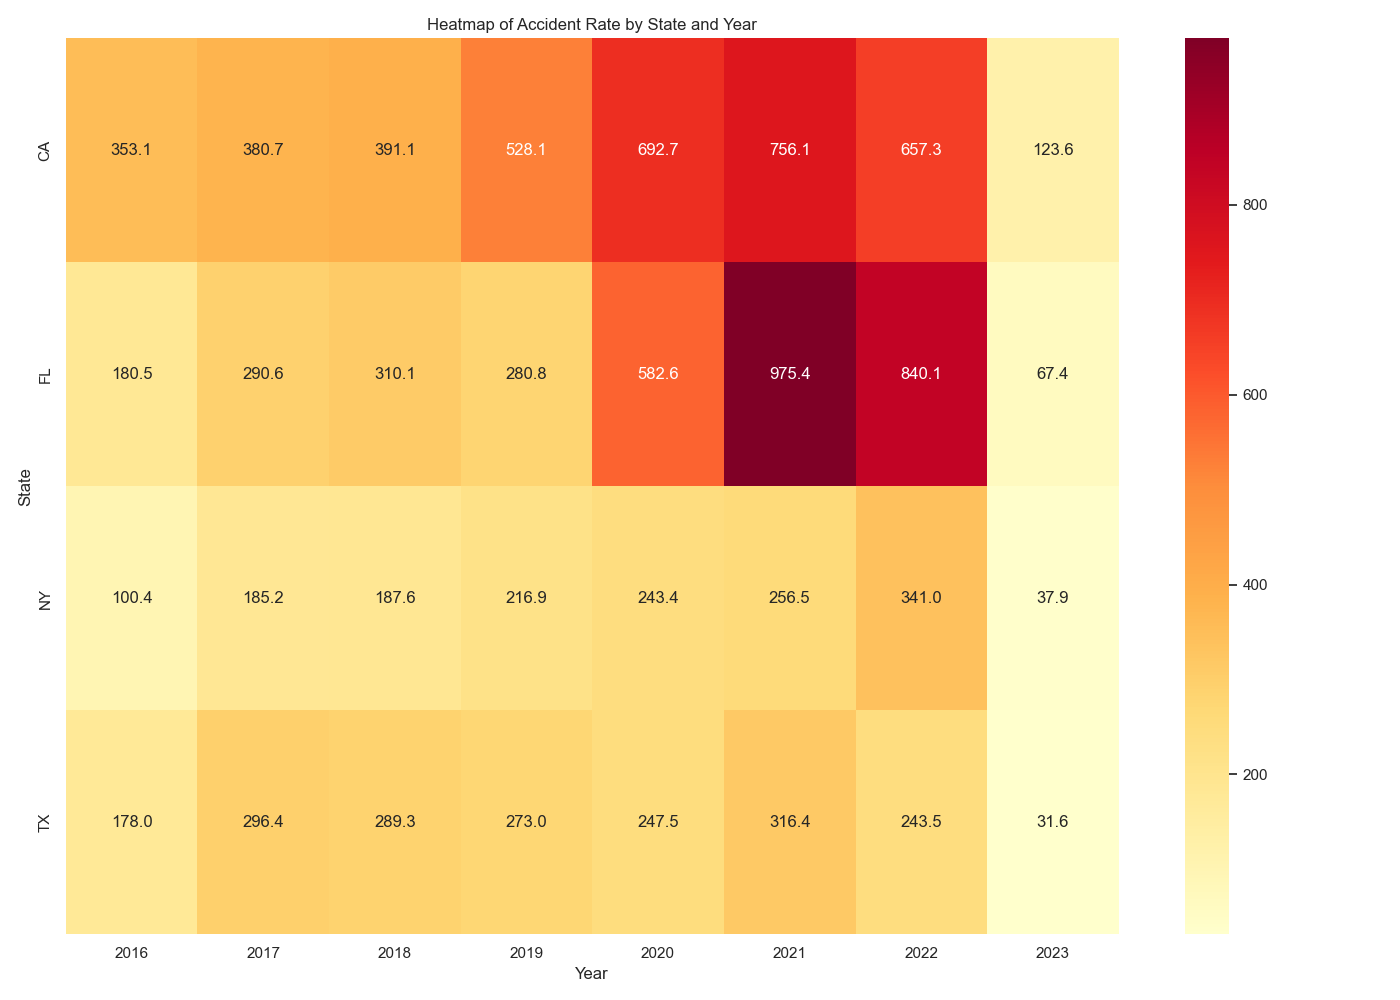

In [61]:
from IPython.display import Image, display

display(Image(filename='outputs/risk_metrics/heatmap_accident_rate.png'))


### **Observations:**

### 🔥 Accident Rate Trends – Normalized by Population

While the raw number of accidents appeared to decline in 2022–2023, the heatmap of accident rates per 100,000 people tells a more nuanced story. During the pandemic and post-pandemic years (2020–2022), states like **California** and **Florida** experienced a sharp increase in accident rates relative to their population.

This counterintuitive trend is supported by national data: although total crashes dropped due to fewer vehicles on the road, the **rate of accidents per mile driven actually increased**. Research suggests this may be attributed to **higher speeding**, **more aggressive driving**, and **reduced law enforcement presence** during lockdown periods. With emptier roads, some drivers engaged in riskier behaviors, which led to proportionally more severe or frequent incidents.

> 📚 **Reference:** National Highway Traffic Safety Administration (NHTSA). *Traffic Safety During the COVID-19 Public Health Emergency: A Look at Speeding-Related, Seat Belt Use, and Alcohol-Impaired Fatal Crashes.* [NHTSA, 2021](https://www.nhtsa.gov/sites/nhtsa.gov/files/2021-10/Traffic-Safety-During-COVID-19-v5-102621.pdf)


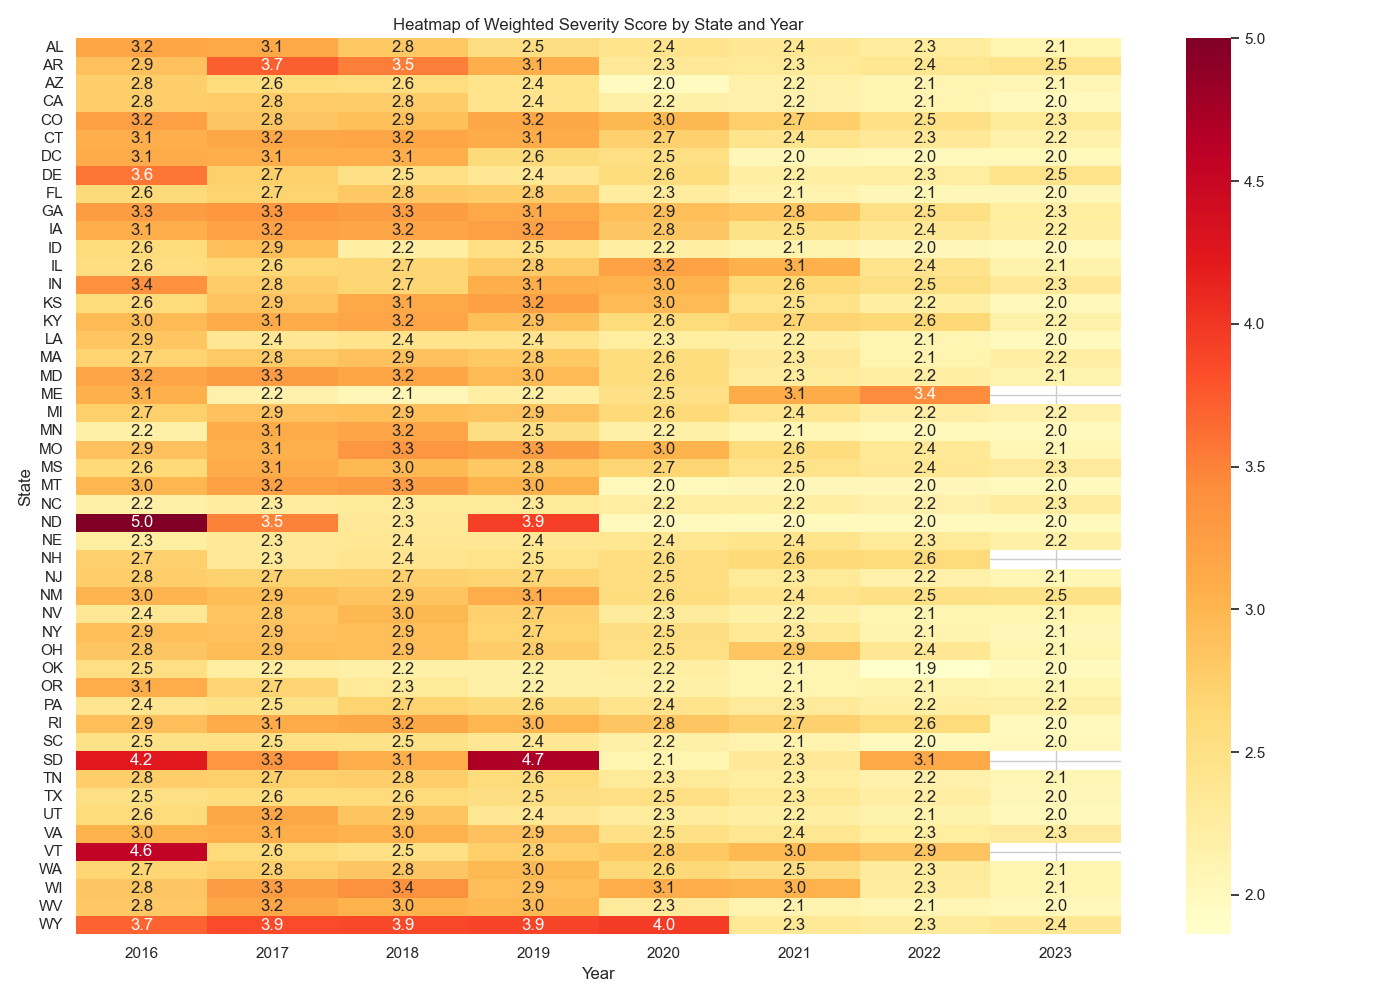

In [62]:
display(Image(filename='outputs/risk_metrics/heatmap_weighted_severity.png'))


### Observations:

**Weighted Severity Score Insights**

This heatmap visualizes the severity-weighted risk score for each state-year pair, where severity levels are mapped as:
- Severity 1 → 1
- Severity 2 → 2
- Severity 3 → 4
- Severity 4 → 5

States like Wyoming (WY), South Dakota (SD), and North Dakota (ND) appear with unusually high scores in some years. This occurs because these are sparsely populated states with relatively few accidents; when a large proportion of those accidents are severe (e.g., level 4), the average risk score becomes inflated. A value of 5.0 indicates that **all recorded accidents that year in that state were of the highest severity**.

These results are statistically valid but should be interpreted cautiously for low-sample regions. For deeper analysis, stratifying by population or applying smoothing techniques may help mitigate sample-size bias.


In [64]:
# Load the correct severity breakdown CSV
severity_df = pd.read_csv('outputs/metrics/severity_breakdown.csv')

# Melt to long format if not already
severity_df = severity_df.melt(id_vars=['Year', 'State'], var_name='Severity', value_name='Count')
severity_df['Severity'] = severity_df['Severity'].astype(int)

# Now filter for WY and inspect
severity_df[severity_df['State'] == 'WY'].groupby(['Year', 'Severity'])['Count'].sum()


Year  Severity
2016  1              0
      2             27
      3              8
      4             33
2017  1              0
      2             37
      3             17
      4             58
2018  1              0
      2             38
      3            106
      4             51
2019  1              0
      2             26
      3             43
      4             41
2020  1              0
      2              8
      3              4
      4             15
2021  1              0
      2            558
      3              0
      4             72
2022  1              0
      2           1093
      3              1
      4            120
2023  1              0
      2            170
      3              0
      4             25
Name: Count, dtype: int64

**Observations:** The unusually high weighted severity scores for Wyoming are due to its very low total number of accidents, where severe cases (Severity 4) make up a disproportionately large share—especially in years like 2020 and 2023. Since the weighted score is an average, even a few high-severity accidents can skew the result upward when the overall count is small.

### 🔄 Re-plotting the Weighted Severity Heatmap (Filtered)

In the initial severity heatmap, some states showed unusually high severity scores despite having very few total accidents. This skewed the interpretation of results, as even a single severe accident in a low-data state could disproportionately raise the average severity.

To address this, we re-plotted the heatmap after filtering out state-year combinations with fewer than 100 total accidents. This ensures that the weighted severity scores are based on sufficient data and are more reliable for comparison. States with low accident counts have been excluded to prevent misleading conclusions.


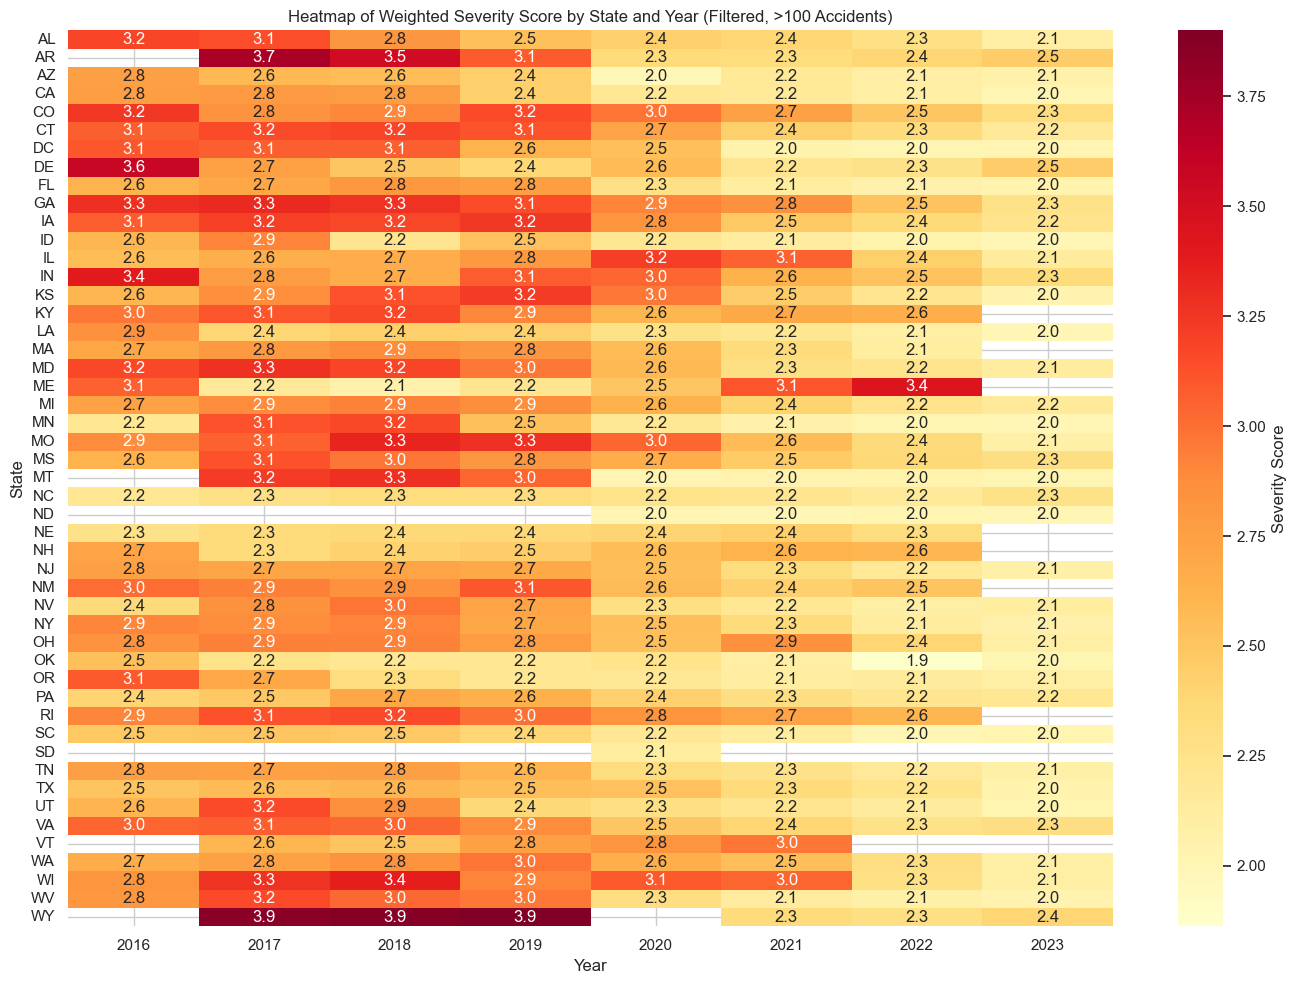

In [67]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Load data
severity_df = pd.read_csv('outputs/metrics/severity_breakdown.csv')

# Melt to long format
severity_long = severity_df.melt(id_vars=['Year', 'State'], var_name='Severity', value_name='Count')
severity_long['Severity'] = severity_long['Severity'].astype(int)

# Add weights
severity_weights = {1: 1, 2: 2, 3: 4, 4: 5}
severity_long['Weight'] = severity_long['Severity'].map(severity_weights)
severity_long['Weighted'] = severity_long['Weight'] * severity_long['Count']

# Group and calculate
grouped = severity_long.groupby(['State', 'Year'])
total_counts = grouped['Count'].sum().reset_index(name='Total_Accidents')
weighted_scores = grouped['Weighted'].sum().reset_index(name='Total_Weighted')
merged = pd.merge(total_counts, weighted_scores, on=['State', 'Year'])
merged['Weighted_Severity_Score'] = merged['Total_Weighted'] / merged['Total_Accidents']

# Filter out low-accident states
filtered = merged[merged['Total_Accidents'] > 100]

# Plot
pivot = filtered.pivot(index='State', columns='Year', values='Weighted_Severity_Score')
plt.figure(figsize=(14, 10))
sns.heatmap(pivot, cmap='YlOrRd', annot=True, fmt='.1f', cbar_kws={'label': 'Severity Score'})
plt.title('Heatmap of Weighted Severity Score by State and Year (Filtered, >100 Accidents)')
plt.tight_layout()
os.makedirs('outputs/risk_metrics', exist_ok=True)
plt.savefig('outputs/risk_metrics/heatmap_weighted_severity_filtered.png')
plt.show()


### Observations:

**Re-plotting Weighted Severity Score with a Minimum Threshold**

In the original heatmap of weighted severity scores, some states with very few total accidents displayed unusually high average severity values, which skewed the visual interpretation. To correct for this, we applied a filtering threshold of **>100 total accidents per state-year** before computing and visualizing the average severity scores.

This adjusted version more accurately reflects severity trends in states with meaningful data volumes, and it reduces the impact of statistical outliers due to low sample sizes. The filtered heatmap provides a more stable comparison across states and years, making it easier to identify consistently high-severity regions.

### Interpretation: Weighted Severity Score Heatmap (Filtered)

This heatmap reveals that **high accident volume does not necessarily correlate with high accident severity**. States like **California (CA), Florida (FL), Texas (TX), and New York (NY)** report the **most total accidents**, but their **severity-weighted scores remain relatively moderate**. This suggests that despite higher traffic density, these states may benefit from **better road infrastructure, traffic management, or emergency response systems**, leading to fewer severe outcomes per accident.

In contrast, states like **Arkansas (AR), Indiana (IN), Delaware (DE), Wyoming (WY), and South Dakota (SD)** exhibit **higher severity scores**, even after filtering for sample size. This indicates that while these states may have **fewer total accidents**, a **larger proportion of them are serious or fatal**. Factors such as **rural road conditions, limited access to trauma care, or higher-speed travel corridors** could contribute to this pattern.

Overall, this visualization highlights the importance of not just tracking how often accidents happen, but also **how severe they are** — especially in regions where sparse traffic may mask underlying safety risks.




### Accidents by Severity and Time of Day

In [39]:
def create_time_of_day_severity_table(df, out_path='outputs/metrics/time_of_day/accidents_by_time_of_day_severity.csv'):
    import os
    os.makedirs(os.path.dirname(out_path), exist_ok=True)

    # Extract hour and create time-of-day labels
    df['Hour'] = df['Start_Time'].dt.hour

    def categorize_hour(hour):
        if 5 <= hour < 12:
            return 'Morning'
        elif 12 <= hour < 17:
            return 'Afternoon'
        elif 17 <= hour < 21:
            return 'Evening'
        else:
            return 'Night'

    df['Time_of_Day'] = df['Hour'].apply(categorize_hour)

    # Group by year, time of day, severity
    grouped = df.groupby(['Year', 'Time_of_Day', 'Severity']).size().reset_index(name='Accident_Count')

    # Save it
    grouped.to_csv(out_path, index=False)
    print(f"✅ Saved: {out_path}")


In [40]:
create_time_of_day_severity_table(df_clean)


✅ Saved: outputs/metrics/time_of_day/accidents_by_time_of_day_severity.csv


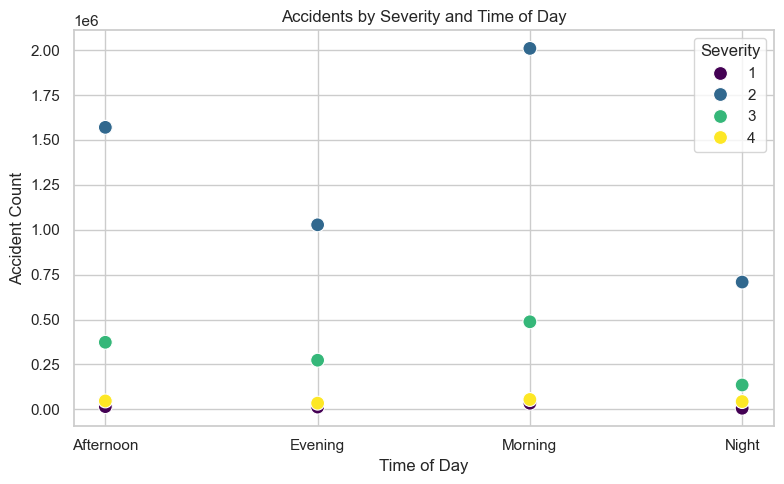

In [66]:
# === Severity vs. Time of Day Scatter Plot ===
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Set output directory
out_dir = 'outputs/risk_metrics/'
os.makedirs(out_dir, exist_ok=True)
sns.set(style='whitegrid')

# Load time of day + severity data
time_df = pd.read_csv('outputs/metrics/time_of_day/accidents_by_time_of_day_severity.csv')

# Group by Time of Day and Severity
time_grouped = time_df.groupby(['Time_of_Day', 'Severity'])['Accident_Count'].sum().reset_index()

# Plot
plt.figure(figsize=(8, 5))
sns.scatterplot(
    data=time_grouped,
    x='Time_of_Day',
    y='Accident_Count',
    hue='Severity',
    palette='viridis',
    s=100
)
plt.title('Accidents by Severity and Time of Day')
plt.ylabel('Accident Count')
plt.xlabel('Time of Day')
plt.tight_layout()
plt.savefig(f"{out_dir}/severity_by_time_of_day.png")
plt.show()


### Observations:

**Accidents by Severity and Time of Day**

This scatter plot shows that **Severity 2** accidents dominate across all times of day, particularly during the **morning** and **afternoon**, which are also the peak windows for overall accident frequency. **Severity 3** accidents follow a similar trend, with a noticeable rise during daytime hours. In contrast, **Severity 1 and 4** accidents are relatively rare throughout the day, indicating that extreme outcomes (either minor or critical) are less common regardless of time, while moderate accidents are most frequent when road activity is highest.


## State Comparison (TOP 3)

### 🔎 State Risk Comparison: California vs. Florida vs. Texas

In [90]:
# Assume you have a DataFrame called `df` with aggregated accident counts
# Columns: Year, State, Severity, Weather_Condition, Time_of_Day, Accident_Count

# Clean column names
df.columns = df.columns.str.strip()

# Filter to valid states
target_states = ['CA', 'FL', 'TX']
df = df[df['State'].isin(target_states)]

# Remove rows with missing or invalid years or accident counts
df = df[df['Year'].between(2016, 2023)]
df = df[df['Accident_Count'].notnull()]

# Create severity-level DataFrame
if 'Severity' in df.columns:
    df_severity = df[['Year', 'State', 'Severity', 'Accident_Count']].dropna()
    df_severity['Severity'] = df_severity['Severity'].astype(str)  # ensure consistency

# Create weather-level DataFrame
if 'Weather_Condition' in df.columns:
    df_weather = df[['Year', 'State', 'Weather_Condition', 'Accident_Count']].dropna()
    # Optionally standardize common weather terms
    df_weather['Weather_Condition'] = df_weather['Weather_Condition'].str.strip().str.title()

# Create time-of-day-level DataFrame
if 'Time_of_Day' in df.columns:
    df_time = df[['Year', 'State', 'Time_of_Day', 'Accident_Count']].dropna()
    df_time['Time_of_Day'] = df_time['Time_of_Day'].str.strip().str.title()

# Confirm structure
print("df_severity:", df_severity.head() if 'df_severity' in locals() else "Not created")
print("df_weather:", df_weather.head() if 'df_weather' in locals() else "Not created")
print("df_time:", df_time.head() if 'df_time' in locals() else "Not created")


df_severity:      Year State  Severity  Accident_Count
0  2016.0    AL         2              74
1  2016.0    AL         3              25
2  2016.0    AL         4              36
3  2016.0    AR         2              17
4  2016.0    AR         3               4
df_weather:      Year State             Weather_Condition  Accident_Count
0  2016.0    AL                         Clear              68
1  2016.0    AL                          Fair               1
2  2016.0    AL                           Fog               1
3  2016.0    AL                    Light Rain               2
4  2016.0    AL  Light Thunderstorms and Rain               2
df_time:     Year State Time_of_Day  Accident_Count
11  2016    CA   Afternoon           40800
12  2016    CA     Evening           35870
13  2016    CA     Morning           39695
14  2016    CA       Night           21861
31  2016    FL   Afternoon            9573


In [92]:
import os

os.makedirs("outputs/3_states", exist_ok=True)


/var/folders/gw/b7p_041n59l085x02_97z5nm0000gp/T/ipykernel_20730/1675860743.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_values)).colors


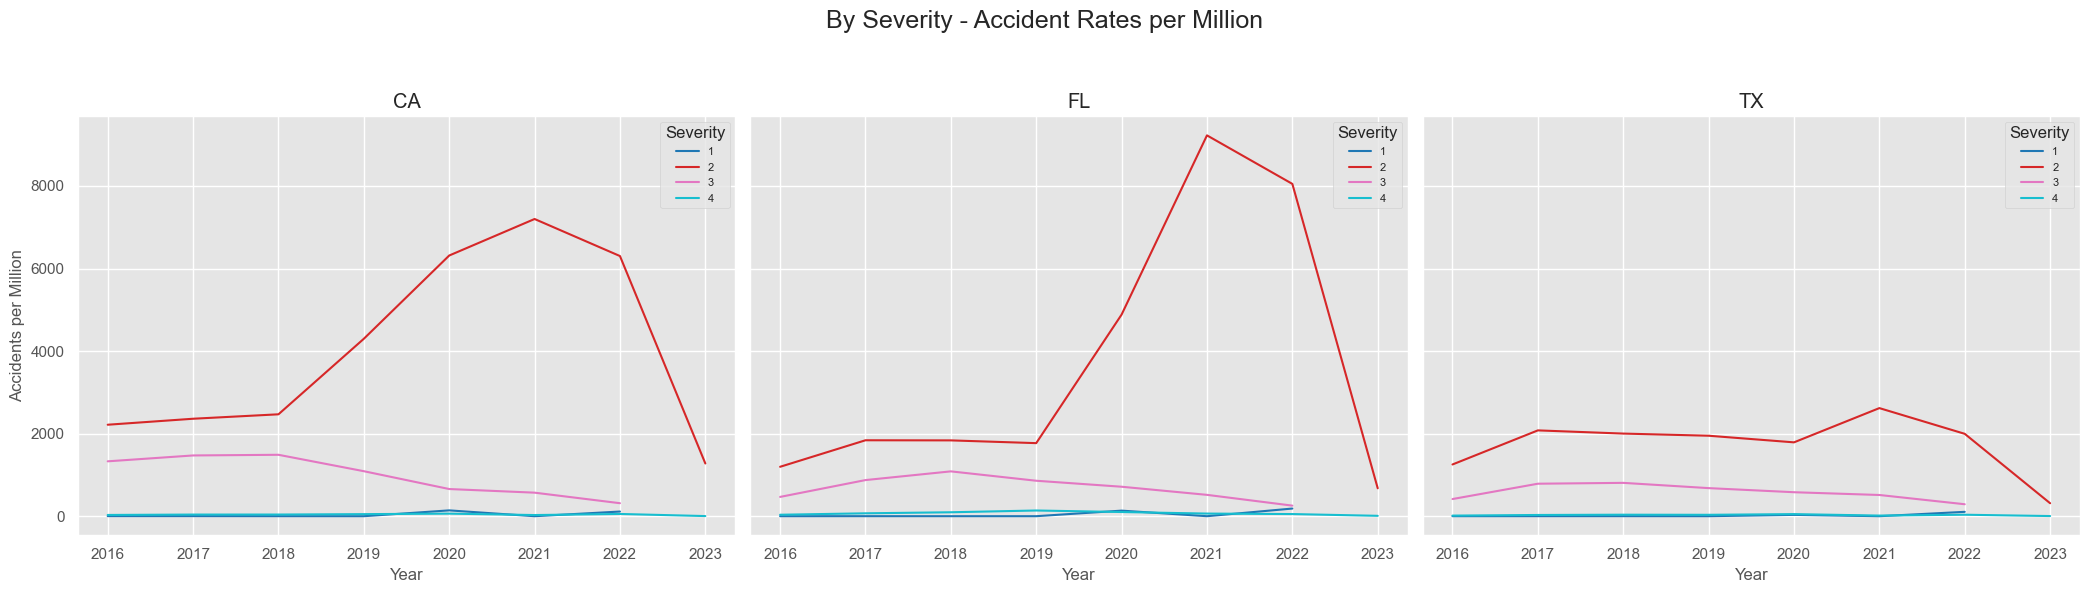

Saved: outputs/3_states/severity_by_state.png


/var/folders/gw/b7p_041n59l085x02_97z5nm0000gp/T/ipykernel_20730/1675860743.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_values)).colors


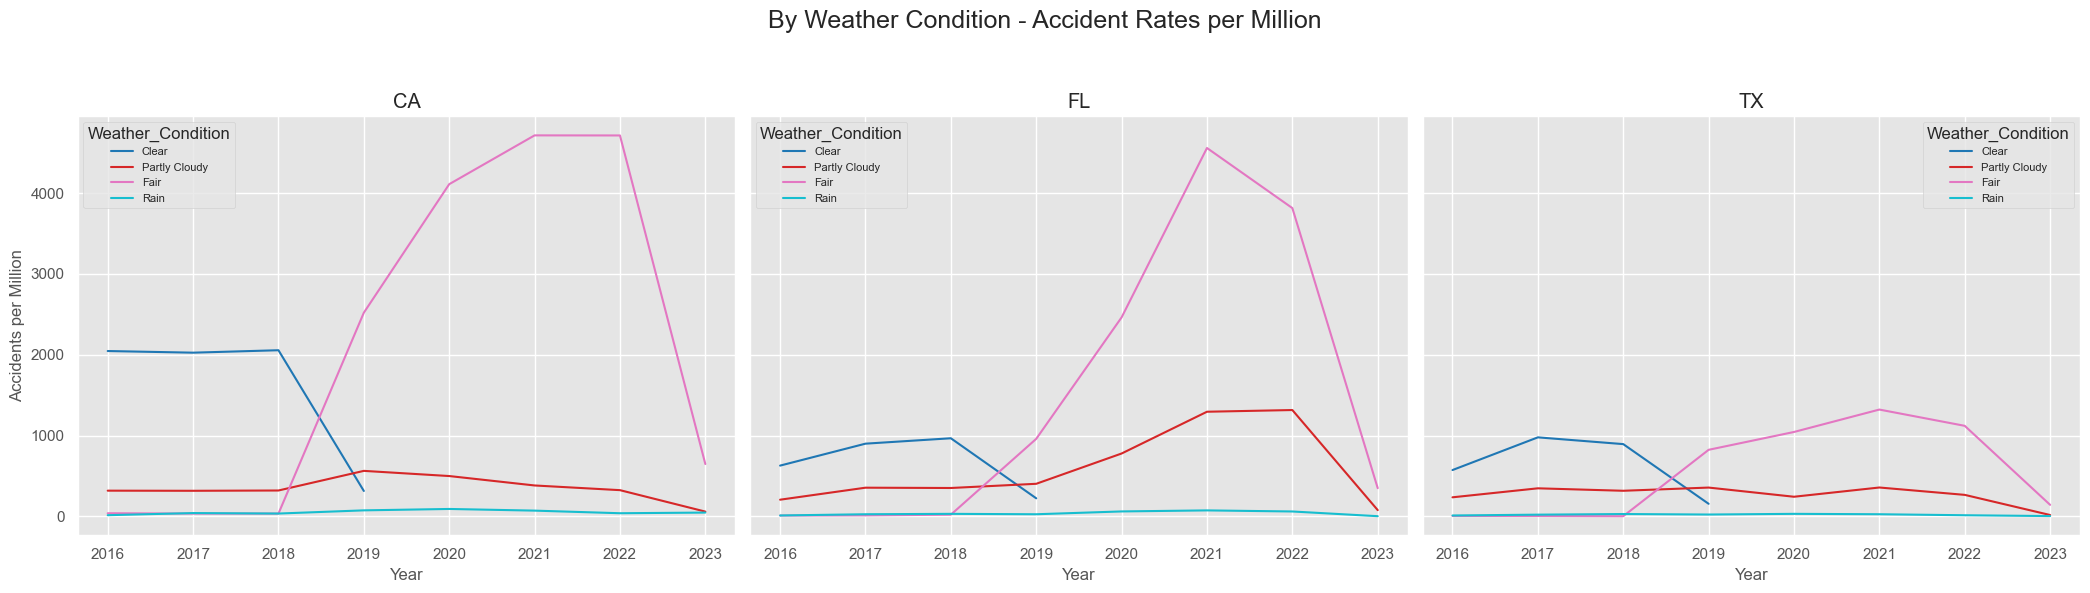

Saved: outputs/3_states/weather_by_state.png


/var/folders/gw/b7p_041n59l085x02_97z5nm0000gp/T/ipykernel_20730/1675860743.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_values)).colors


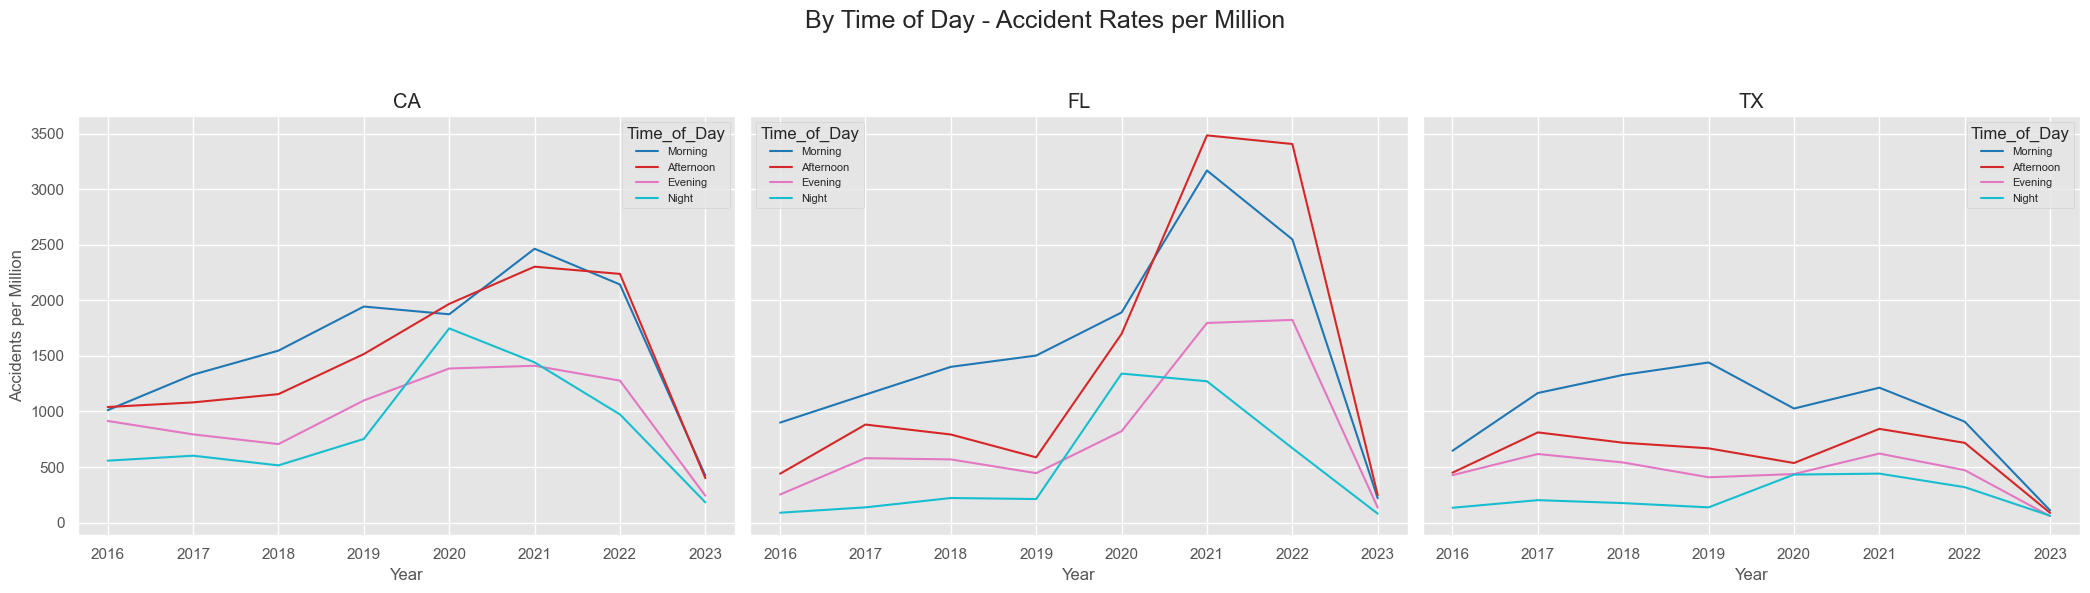

Saved: outputs/3_states/timeofday_by_state.png


In [94]:
import pandas as pd
import matplotlib.pyplot as plt

# ---------- Configuration ----------
state_population = {
    'CA': 39.24,
    'FL': 21.78,
    'TX': 29.53
}
target_states = ['CA', 'FL', 'TX']

def plot_statewise_subplots(df, category, title_prefix, top_categories=None, save_path=None):
    """
    Create a figure with 3 subplots (CA, FL, TX) for a given stratification (category).
    Each subplot shows accident rates per year for that category.
    """
    fig, axs = plt.subplots(1, 3, figsize=(21, 6), sharey=True)
    fig.suptitle(f"{title_prefix} - Accident Rates per Million", fontsize=18)

    # Limit to top categories (optional)
    if top_categories:
        df = df[df[category].isin(top_categories)]
        unique_values = top_categories
    else:
        unique_values = sorted(df[category].dropna().unique())

    colors = plt.cm.get_cmap('tab10', len(unique_values)).colors

    for i, state in enumerate(target_states):
        ax = axs[i]
        state_df = df[df['State'] == state].copy()
        state_df['Population'] = state_df['State'].map(state_population)
        state_df['Accident_Rate'] = state_df['Accident_Count'] / state_df['Population']

        for j, val in enumerate(unique_values):
            sub_df = state_df[state_df[category] == val]
            if not sub_df.empty:
                ax.plot(sub_df['Year'], sub_df['Accident_Rate'], label=val, color=colors[j])
        
        ax.set_title(f"{state}")
        ax.set_xlabel("Year")
        if i == 0:
            ax.set_ylabel("Accidents per Million")
        ax.legend(title=category, fontsize=8)

    plt.tight_layout(rect=[0, 0, 1, 0.93])
    if save_path:
        plt.savefig(save_path, dpi=300)
    plt.show()
    print(f"Saved: {save_path}")

# ---------- Call the Function with Each Stratification ----------

# Plot 1: By Severity
plot_statewise_subplots(
    df_severity,
    category="Severity",
    title_prefix="By Severity",
    save_path="outputs/3_states/severity_by_state.png"
)

# Plot 2: By Weather Condition (limit to top 4 known weather types)
plot_statewise_subplots(
    df_weather,
    category="Weather_Condition",
    title_prefix="By Weather Condition",
    top_categories=["Clear", "Partly Cloudy", "Fair", "Rain"],
    save_path="outputs/3_states/weather_by_state.png"
)

# Plot 3: By Time of Day
plot_statewise_subplots(
    df_time,
    category="Time_of_Day",
    title_prefix="By Time of Day",
    top_categories=["Morning", "Afternoon", "Evening", "Night"],
    save_path="outputs/3_states/timeofday_by_state.png"
)


## 📊 Summary of Observations: California, Florida, and Texas (2016–2023)

Across all three states — **California, Florida, and Texas** — we observe consistent patterns in accident rates over time:

### 🚦 Severity Trends
- **Severity level 2 accidents** are by far the most common in all three states. Their rates **increased steadily from 2018**, **peaked around 2021**, and then declined toward 2023.
- The sharp drop in 2023 is likely due to **incomplete data** for that year.
- **Severity 3 accidents** have been decreasing since around **2018**, suggesting a positive trend in reducing more serious incidents.
- Accidents of **severity 1 and 4** remain **rare and relatively stable** across all years and states.

### 🌦️ Weather Conditions
- Most accidents occurred under **Fair** and **Partly Cloudy** weather, with **Fair weather dominating** post-2018 and **Clear weather** appearing mostly before 2019.
- The disappearance of "Clear" and rise of "Fair" conditions in later years may reflect **changes in data labeling or categorization** rather than actual weather shifts.
- **Rain** contributes a small but consistent share of accidents.

### ⏰ Time of Day
- **Morning and Afternoon** are the peak periods for accidents across all three states.
- In **Texas**, **morning accidents consistently exceed afternoon ones**, while in **California** and **Florida**, the dominant time period fluctuates by year.
- **Evening and Night** accidents remain lower but follow similar overall trends.


In [98]:
# Set the path to your dataset 
csv_path = '../data/US_Accidents_March23.csv'

# Load full dataset
df_raw = pd.read_csv(csv_path)



In [99]:
print(df_raw.head())               # If using raw data


    ID   Source  Severity           Start_Time             End_Time  \
0  A-1  Source2         3  2016-02-08 05:46:00  2016-02-08 11:00:00   
1  A-2  Source2         2  2016-02-08 06:07:59  2016-02-08 06:37:59   
2  A-3  Source2         2  2016-02-08 06:49:27  2016-02-08 07:19:27   
3  A-4  Source2         3  2016-02-08 07:23:34  2016-02-08 07:53:34   
4  A-5  Source2         2  2016-02-08 07:39:07  2016-02-08 08:09:07   

   Start_Lat  Start_Lng  End_Lat  End_Lng  Distance(mi)  ... Roundabout  \
0  39.865147 -84.058723      NaN      NaN          0.01  ...      False   
1  39.928059 -82.831184      NaN      NaN          0.01  ...      False   
2  39.063148 -84.032608      NaN      NaN          0.01  ...      False   
3  39.747753 -84.205582      NaN      NaN          0.01  ...      False   
4  39.627781 -84.188354      NaN      NaN          0.01  ...      False   

  Station   Stop Traffic_Calming Traffic_Signal Turning_Loop Sunrise_Sunset  \
0   False  False           False          F

In [100]:
print(df_raw['State'].unique())    # Check state codes


['OH' 'WV' 'CA' 'FL' 'GA' 'SC' 'NE' 'IA' 'IL' 'MO' 'WI' 'IN' 'MI' 'NJ'
 'NY' 'CT' 'MA' 'RI' 'NH' 'PA' 'KY' 'MD' 'VA' 'DC' 'DE' 'TX' 'WA' 'OR'
 'AL' 'NC' 'AZ' 'TN' 'LA' 'MN' 'CO' 'OK' 'NV' 'UT' 'KS' 'NM' 'AR' 'MS'
 'ME' 'VT' 'WY' 'ID' 'ND' 'MT' 'SD']


In [125]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Group by state
grouped = df_raw.groupby('State')
state_stats = pd.DataFrame({
    'Accident_Count': grouped.size(),
    'Avg_Severity': grouped['Severity'].mean()
})

# Add population for all states + DC
state_population = {
    'AL': 5024279, 'AK': 733391, 'AZ': 7151502, 'AR': 3011524, 'CA': 39538223,
    'CO': 5773714, 'CT': 3605944, 'DE': 989948, 'FL': 21538187, 'GA': 10711908,
    'HI': 1455271, 'ID': 1839106, 'IL': 12812508, 'IN': 6785528, 'IA': 3190369,
    'KS': 2937880, 'KY': 4505836, 'LA': 4657757, 'ME': 1362359, 'MD': 6177224,
    'MA': 7029917, 'MI': 10077331, 'MN': 5706494, 'MS': 2961279, 'MO': 6154913,
    'MT': 1084225, 'NE': 1961504, 'NV': 3104614, 'NH': 1377529, 'NJ': 9288994,
    'NM': 2117522, 'NY': 20201249, 'NC': 10439388, 'ND': 779094, 'OH': 11799448,
    'OK': 3959353, 'OR': 4237256, 'PA': 13002700, 'RI': 1097379, 'SC': 5118425,
    'SD': 886667, 'TN': 6910840, 'TX': 29145505, 'UT': 3271616, 'VT': 643077,
    'VA': 8631393, 'WA': 7693612, 'WV': 1793716, 'WI': 5893718, 'WY': 576851, 'DC': 689545
}
state_stats['Population'] = state_stats.index.map(state_population)

# Drop states with missing population
state_stats = state_stats.dropna(subset=['Population'])

# Compute Accident Rate
state_stats['Accident_Rate'] = (state_stats['Accident_Count'] / state_stats['Population']) * 100000

In [128]:
# Add full state names from abbreviation
state_abbrev_to_name = {
    'AL': 'Alabama', 'AK': 'Alaska', 'AZ': 'Arizona', 'AR': 'Arkansas', 'CA': 'California',
    'CO': 'Colorado', 'CT': 'Connecticut', 'DE': 'Delaware', 'FL': 'Florida', 'GA': 'Georgia',
    'HI': 'Hawaii', 'ID': 'Idaho', 'IL': 'Illinois', 'IN': 'Indiana', 'IA': 'Iowa',
    'KS': 'Kansas', 'KY': 'Kentucky', 'LA': 'Louisiana', 'ME': 'Maine', 'MD': 'Maryland',
    'MA': 'Massachusetts', 'MI': 'Michigan', 'MN': 'Minnesota', 'MS': 'Mississippi', 'MO': 'Missouri',
    'MT': 'Montana', 'NE': 'Nebraska', 'NV': 'Nevada', 'NH': 'New Hampshire', 'NJ': 'New Jersey',
    'NM': 'New Mexico', 'NY': 'New York', 'NC': 'North Carolina', 'ND': 'North Dakota', 'OH': 'Ohio',
    'OK': 'Oklahoma', 'OR': 'Oregon', 'PA': 'Pennsylvania', 'RI': 'Rhode Island', 'SC': 'South Carolina',
    'SD': 'South Dakota', 'TN': 'Tennessee', 'TX': 'Texas', 'UT': 'Utah', 'VT': 'Vermont',
    'VA': 'Virginia', 'WA': 'Washington', 'WV': 'West Virginia', 'WI': 'Wisconsin', 'WY': 'Wyoming', 'DC': 'District of Columbia'
}

# Add 'State_Name' column
state_stats['State_Name'] = state_stats.index.map(state_abbrev_to_name)


In [131]:
import folium

# Reuse the same GeoJSON URL
geojson_url = 'https://raw.githubusercontent.com/PublicaMundi/MappingAPI/master/data/geojson/us-states.json'

# Create a fresh map
m_accident_rate = folium.Map(location=[37.8, -96], zoom_start=4)

# Plot raw Accident Rate
folium.Choropleth(
    geo_data=geojson_url,
    name='Accident Rate',
    data=state_stats,
    columns=['State_Name', 'Accident_Rate'],  # raw values
    key_on='feature.properties.name',
    fill_color='YlGnBu',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Accident Rate per 100,000 People',
    nan_fill_color='gray'
).add_to(m_accident_rate)

# Optional tooltip
folium.GeoJson(
    geojson_url,
    name="Labels",
    tooltip=folium.GeoJsonTooltip(fields=["name"], aliases=["State:"]),
    style_function=lambda x: {"fillOpacity": 0, "color": "transparent"},
).add_to(m_accident_rate)

# Show map in notebook
m_accident_rate


### Traffic Accident Rate per 100,000 Residents by U.S. State

![Accident Rate Map](accident_rate_per_100k.png)

This choropleth map displays the **traffic accident rate per 100,000 residents** for each U.S. state, based on raw accident counts normalized by 2020 Census population data.

#### Key Insights:
- **South Carolina** stands out with the **highest accident rate**, exceeding 7,400 incidents per 100,000 people — potentially due to overrepresentation in the dataset or a genuinely high incidence rate.
- **California, Florida, and Texas**, while having high total accidents, appear less extreme here due to their large populations.
- Smaller states with **moderate accident volumes but low populations** (e.g., Rhode Island, Delaware) also show elevated rates.
- States shaded in yellow reflect **relatively lower exposure risk**, either due to fewer incidents or larger populations diluting the rate.

This map offers a more balanced view than raw accident counts by adjusting for population, making it easier to compare states on an equal footing.


In [142]:
import folium

# Public GeoJSON URL
geojson_url = 'https://raw.githubusercontent.com/PublicaMundi/MappingAPI/master/data/geojson/us-states.json'

# Create base map
m_severity = folium.Map(location=[37.8, -96], zoom_start=4)

# Plot average severity
folium.Choropleth(
    geo_data=geojson_url,
    name='Avg Severity',
    data=state_stats,
    columns=['State_Name', 'Avg_Severity'],
    key_on='feature.properties.name',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Average Accident Severity (1 = Low, 4 = High)',
    nan_fill_color='gray'
).add_to(m_severity)

# Optional tooltip
folium.GeoJson(
    geojson_url,
    name="Labels",
    tooltip=folium.GeoJsonTooltip(fields=["name"], aliases=["State:"]),
    style_function=lambda x: {"fillOpacity": 0, "color": "transparent"},
).add_to(m_severity)

# Display map in notebook
m_severity


### ⚠️ Average Traffic Accident Severity by U.S. State

![Severity Map](avg_severity_by_state.png)

This map displays the **average severity** of traffic accidents across U.S. states, with severity scores ranging from:
- **1 (Minor)** to **4 (Severe)**

#### 🔍 Key Findings:
- States like **Georgia, Rhode Island, Wisconsin, Colorado, Kentucky, South Dakota, and Vermont** show the **highest average severity scores**.
- These states may not have the highest accident counts, but their accidents tend to be **more dangerous**.
- **Smaller states** (e.g., RI, VT, SD) can show high severity due to just a few severe events in a low-volume dataset.
- In contrast, **California, New York, and Texas** report many accidents but average lower severity due to higher share of minor incidents.

This map reveals states where accidents tend to be **more serious**, offering a different lens on public safety than frequency-based metrics alone.


### 🧮 Composite Risk Score Analysis

To quantify accident risk across U.S. states, we defined a **Composite Risk Score** that integrates both frequency and severity of accidents. This provides a more holistic measure of risk than using either metric alone.

#### ✅ Methodology

For each state, we computed:
- **Accident Rate per 100,000 residents**  
  `Accident_Rate = (Accident_Count / Population) × 100,000`

- **Average Severity Score**  
  Based on the 'Severity' variable in the dataset (1 = least severe, 4 = most severe).

We then **normalized** both `Accident_Rate` and `Avg_Severity` using MinMax scaling and calculated a **Composite Risk Score**:

```python
Composite_Risk_Score = 0.5 × normalized_accident_rate + 0.5 × normalized_severity

In [134]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Group by state
grouped = df_raw.groupby('State')
state_stats = pd.DataFrame({
    'Accident_Count': grouped.size(),
    'Avg_Severity': grouped['Severity'].mean()
})

# Add population for all states + DC
state_population = {
    'AL': 5024279, 'AK': 733391, 'AZ': 7151502, 'AR': 3011524, 'CA': 39538223,
    'CO': 5773714, 'CT': 3605944, 'DE': 989948, 'FL': 21538187, 'GA': 10711908,
    'HI': 1455271, 'ID': 1839106, 'IL': 12812508, 'IN': 6785528, 'IA': 3190369,
    'KS': 2937880, 'KY': 4505836, 'LA': 4657757, 'ME': 1362359, 'MD': 6177224,
    'MA': 7029917, 'MI': 10077331, 'MN': 5706494, 'MS': 2961279, 'MO': 6154913,
    'MT': 1084225, 'NE': 1961504, 'NV': 3104614, 'NH': 1377529, 'NJ': 9288994,
    'NM': 2117522, 'NY': 20201249, 'NC': 10439388, 'ND': 779094, 'OH': 11799448,
    'OK': 3959353, 'OR': 4237256, 'PA': 13002700, 'RI': 1097379, 'SC': 5118425,
    'SD': 886667, 'TN': 6910840, 'TX': 29145505, 'UT': 3271616, 'VT': 643077,
    'VA': 8631393, 'WA': 7693612, 'WV': 1793716, 'WI': 5893718, 'WY': 576851, 'DC': 689545
}
state_stats['Population'] = state_stats.index.map(state_population)

# Drop states with missing population
state_stats = state_stats.dropna(subset=['Population'])

# Compute Accident Rate
state_stats['Accident_Rate'] = (state_stats['Accident_Count'] / state_stats['Population']) * 100000

# Normalize
scaler = MinMaxScaler()
state_stats[['Rate_Norm', 'Severity_Norm']] = scaler.fit_transform(
    state_stats[['Accident_Rate', 'Avg_Severity']]
)

# Composite Risk Score with equal weights
state_stats['Composite_Risk_Score'] = (
    0.5 * state_stats['Rate_Norm'] + 0.5 * state_stats['Severity_Norm']
)
state_stats['Risk_Rank'] = state_stats['Composite_Risk_Score'].rank(ascending=False)


In [137]:
# Add full state names from abbreviation
state_abbrev_to_name = {
    'AL': 'Alabama', 'AK': 'Alaska', 'AZ': 'Arizona', 'AR': 'Arkansas', 'CA': 'California',
    'CO': 'Colorado', 'CT': 'Connecticut', 'DE': 'Delaware', 'FL': 'Florida', 'GA': 'Georgia',
    'HI': 'Hawaii', 'ID': 'Idaho', 'IL': 'Illinois', 'IN': 'Indiana', 'IA': 'Iowa',
    'KS': 'Kansas', 'KY': 'Kentucky', 'LA': 'Louisiana', 'ME': 'Maine', 'MD': 'Maryland',
    'MA': 'Massachusetts', 'MI': 'Michigan', 'MN': 'Minnesota', 'MS': 'Mississippi', 'MO': 'Missouri',
    'MT': 'Montana', 'NE': 'Nebraska', 'NV': 'Nevada', 'NH': 'New Hampshire', 'NJ': 'New Jersey',
    'NM': 'New Mexico', 'NY': 'New York', 'NC': 'North Carolina', 'ND': 'North Dakota', 'OH': 'Ohio',
    'OK': 'Oklahoma', 'OR': 'Oregon', 'PA': 'Pennsylvania', 'RI': 'Rhode Island', 'SC': 'South Carolina',
    'SD': 'South Dakota', 'TN': 'Tennessee', 'TX': 'Texas', 'UT': 'Utah', 'VT': 'Vermont',
    'VA': 'Virginia', 'WA': 'Washington', 'WV': 'West Virginia', 'WI': 'Wisconsin', 'WY': 'Wyoming', 'DC': 'District of Columbia'
}

# Add 'State_Name' column
state_stats['State_Name'] = state_stats.index.map(state_abbrev_to_name)

In [138]:
# View or export table
print(state_stats.sort_values('Composite_Risk_Score', ascending=False).head(10))

# Save to CSV
state_stats.to_csv("state_risk_scores.csv")


       Accident_Count  Avg_Severity  Population  Accident_Rate  Rate_Norm  \
State                                                                       
GA             169234      2.506931    10711908    1579.867938   0.207924   
SC             382557      2.111055     5118425    7474.115573   1.000000   
RI              16971      2.458252     1097379    1546.503077   0.203441   
CO              90885      2.443902     5773714    1574.116764   0.207152   
WI              34688      2.473939     5893718     588.558869   0.074711   
VA             303301      2.278974     8631393    3513.928748   0.467826   
KY              32254      2.454176     4505836     715.827207   0.091814   
MD             140417      2.332702     6177224    2273.140815   0.301087   
MO              77323      2.399609     6154913    1256.280958   0.164440   
CT              71005      2.347032     3605944    1969.109892   0.260231   

       Severity_Norm  Composite_Risk_Score  Risk_Rank      State_Name  
Sta

In [141]:

state_stats[['State_Name', 'Accident_Count', 'Population',
             'Accident_Rate', 'Avg_Severity', 'Rate_Norm',
             'Severity_Norm', 'Composite_Risk_Score']
].sort_values('Composite_Risk_Score', ascending=False).head(15)


State_Name  Accident_Count  Population  Accident_Rate  \
State                                                              
GA            Georgia          169234    10711908    1579.867938   
SC     South Carolina          382557     5118425    7474.115573   
RI       Rhode Island           16971     1097379    1546.503077   
CO           Colorado           90885     5773714    1574.116764   
WI          Wisconsin           34688     5893718     588.558869   
VA           Virginia          303301     8631393    3513.928748   
KY           Kentucky           32254     4505836     715.827207   
MD           Maryland          140417     6177224    2273.140815   
MO           Missouri           77323     6154913    1256.280958   
CT        Connecticut           71005     3605944    1969.109892   
IA               Iowa           26307     3190369     824.575464   
IL           Illinois          168958    12812508    1318.695762   
IN            Indiana           67224     6785528     990.696671   
CA         California         1741433    39538223    4404.429101   
SD       South Dakota             289      886667      32.593973   

       Avg_Severity  Rate_Norm  Severity_Norm  Composite_Risk_Score  
State                                                                
GA         2.506931   0.207924       1.000000              0.603962  
SC         2.111055   1.000000       0.197743              0.598871  
RI         2.458252   0.203441       0.901350              0.552396  
CO         2.443902   0.207152       0.872268              0.539710  
WI         2.473939   0.074711       0.933140              0.503926  
VA         2.278974   0.467826       0.538036              0.502931  
KY         2.454176   0.091814       0.893090              0.492452  
MD         2.332702   0.301087       0.646918              0.474002  
MO         2.399609   0.164440       0.782508              0.473474  
CT         2.347032   0.260231       0.675958              0.468095  
IA         2.419432   0.106427       0.822680              0.464554  
IL         2.383302   0.172828       0.749462              0.461145  
IN         2.398072   0.128751       0.779393              0.454072  
CA         2.165688   0.587492       0.308457              0.447975  
SD         2.442907   0.000000       0.870252              0.435126

### Geospatial Map of Composite Risk Score 🌎 

In [113]:
!pip install folium


In [115]:
import requests
import json

# Load GeoJSON
geojson_url = 'https://raw.githubusercontent.com/PublicaMundi/MappingAPI/master/data/geojson/us-states.json'
geojson_data = requests.get(geojson_url).json()

# Print property keys for the first feature
print(geojson_data['features'][0]['properties'].keys())


dict_keys(['name', 'density'])


In [116]:
import folium
import pandas as pd

# Step 1: Add full state names to your state_stats DataFrame
state_abbrev_to_name = {
    'AL': 'Alabama', 'AK': 'Alaska', 'AZ': 'Arizona', 'AR': 'Arkansas', 'CA': 'California',
    'CO': 'Colorado', 'CT': 'Connecticut', 'DE': 'Delaware', 'FL': 'Florida', 'GA': 'Georgia',
    'HI': 'Hawaii', 'ID': 'Idaho', 'IL': 'Illinois', 'IN': 'Indiana', 'IA': 'Iowa',
    'KS': 'Kansas', 'KY': 'Kentucky', 'LA': 'Louisiana', 'ME': 'Maine', 'MD': 'Maryland',
    'MA': 'Massachusetts', 'MI': 'Michigan', 'MN': 'Minnesota', 'MS': 'Mississippi', 'MO': 'Missouri',
    'MT': 'Montana', 'NE': 'Nebraska', 'NV': 'Nevada', 'NH': 'New Hampshire', 'NJ': 'New Jersey',
    'NM': 'New Mexico', 'NY': 'New York', 'NC': 'North Carolina', 'ND': 'North Dakota', 'OH': 'Ohio',
    'OK': 'Oklahoma', 'OR': 'Oregon', 'PA': 'Pennsylvania', 'RI': 'Rhode Island', 'SC': 'South Carolina',
    'SD': 'South Dakota', 'TN': 'Tennessee', 'TX': 'Texas', 'UT': 'Utah', 'VT': 'Vermont',
    'VA': 'Virginia', 'WA': 'Washington', 'WV': 'West Virginia', 'WI': 'Wisconsin', 'WY': 'Wyoming', 'DC': 'District of Columbia'
}

state_stats = state_stats.reset_index()
state_stats['State_Name'] = state_stats['State'].map(state_abbrev_to_name)

# Step 2: Define the GeoJSON URL
geojson_url = 'https://raw.githubusercontent.com/PublicaMundi/MappingAPI/master/data/geojson/us-states.json'

# Step 3: Create and render the map
m = folium.Map(location=[37.8, -96], zoom_start=4)

folium.Choropleth(
    geo_data=geojson_url,
    name='choropleth',
    data=state_stats,
    columns=['State_Name', 'Composite_Risk_Score'],
    key_on='feature.properties.name',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Composite Risk Score',
    nan_fill_color='gray'
).add_to(m)

# OPTIONAL: Tooltip with state name
tooltip = folium.GeoJson(
    geojson_url,
    name="State Labels",
    tooltip=folium.GeoJsonTooltip(fields=["name"], aliases=["State:"]),
    style_function=lambda x: {"fillOpacity": 0, "color": "transparent"},
)
tooltip.add_to(m)

# Step 4: Display the map in notebook
m


In [117]:
m.save("us_composite_risk_map.html")


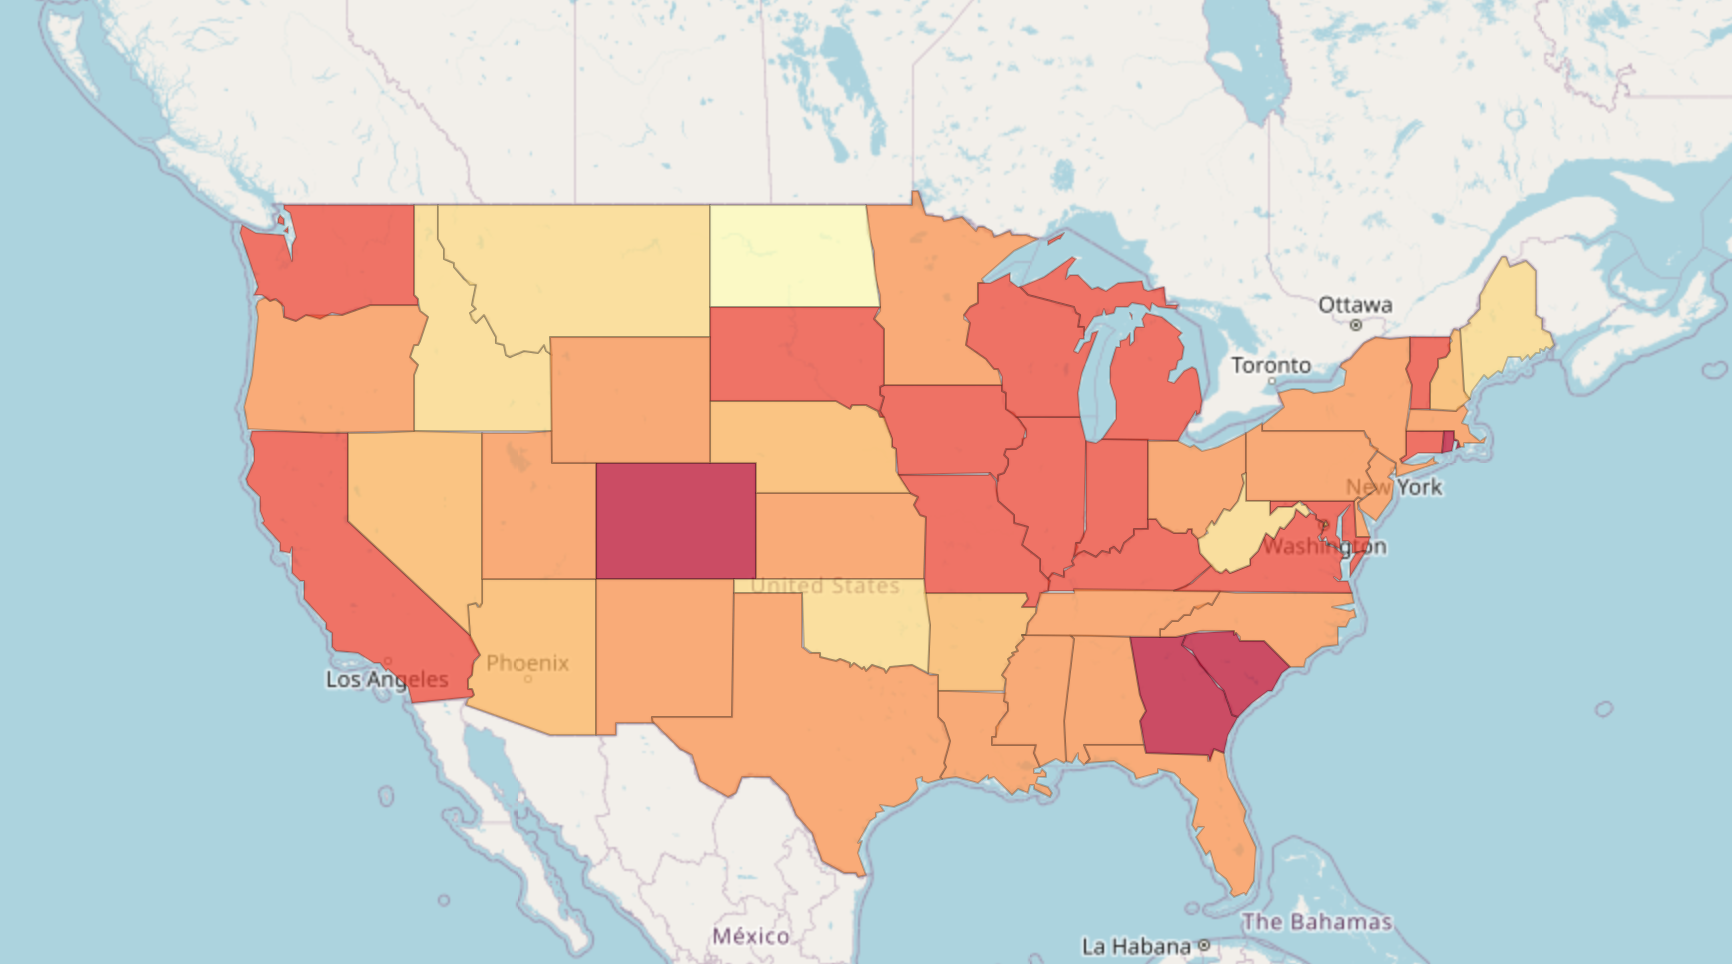

In [123]:
from IPython.display import Image, display

display(Image(filename='composite_risk_map.png'))


**Figure:** Composite Risk Score by US State based on normalized accident rate and severity score.


In [120]:
state_stats[['State', 'State_Name', 'Accident_Count', 'Population',
             'Accident_Rate', 'Avg_Severity', 'Rate_Norm',
             'Severity_Norm', 'Composite_Risk_Score']
].sort_values('Composite_Risk_Score', ascending=False).head(15)

State      State_Name  Accident_Count  Population  Accident_Rate  \
9     GA         Georgia          169234    10711908    1579.867938   
38    SC  South Carolina          382557     5118425    7474.115573   
37    RI    Rhode Island           16971     1097379    1546.503077   
4     CO        Colorado           90885     5773714    1574.116764   
46    WI       Wisconsin           34688     5893718     588.558869   
43    VA        Virginia          303301     8631393    3513.928748   
15    KY        Kentucky           32254     4505836     715.827207   
18    MD        Maryland          140417     6177224    2273.140815   
22    MO        Missouri           77323     6154913    1256.280958   
5     CT     Connecticut           71005     3605944    1969.109892   
10    IA            Iowa           26307     3190369     824.575464   
12    IL        Illinois          168958    12812508    1318.695762   
13    IN         Indiana           67224     6785528     990.696671   
3     CA      California         1741433    39538223    4404.429101   
39    SD    South Dakota             289      886667      32.593973   

    Avg_Severity  Rate_Norm  Severity_Norm  Composite_Risk_Score  
9       2.506931   0.207924       1.000000              0.603962  
38      2.111055   1.000000       0.197743              0.598871  
37      2.458252   0.203441       0.901350              0.552396  
4       2.443902   0.207152       0.872268              0.539710  
46      2.473939   0.074711       0.933140              0.503926  
43      2.278974   0.467826       0.538036              0.502931  
15      2.454176   0.091814       0.893090              0.492452  
18      2.332702   0.301087       0.646918              0.474002  
22      2.399609   0.164440       0.782508              0.473474  
5       2.347032   0.260231       0.675958              0.468095  
10      2.419432   0.106427       0.822680              0.464554  
12      2.383302   0.172828       0.749462              0.461145  
13      2.398072   0.128751       0.779393              0.454072  
3       2.165688   0.587492       0.308457              0.447975  
39      2.442907   0.000000       0.870252              0.435126

# 🧮 Key Findings – Composite Risk Score Analysis

We computed a **Composite Risk Score** for each U.S. state using:

- **Accident Rate** per 100,000 people
- **Average Severity** (1 = low, 4 = high)

Both were normalized to [0, 1], and the final score is:

`Composite Risk Score = 0.5 × Normalized_Accident_Rate + 0.5 × Normalized_Severity`

---

#### 🔥 Highest-Risk States

These states rank highest in composite risk due to a combination of **high accident frequency** and/or **high severity**:

| State | Accident Rate | Avg Severity | Composite Score | Notes |
|-------|----------------|---------------|------------------|----------------------------|
| **GA** | 1579.9 | **2.51** | **0.604** | Moderate rate, **max severity** |
| **SC** | **7474.1** | 2.11 | **0.599** | **Highest rate** in U.S. |
| **RI** | 1546.5 | 2.46 | **0.552** | High severity, small population |
| **CO** | 1574.1 | 2.44 | **0.540** | Balanced rate and severity |

---

#### 🟧 Elevated Risk States

States like **California**, **Wisconsin**, **Maryland**, and **Illinois** show moderate-to-high risk due to either high accident numbers or severity.

- **California (CA)**: High accident volume, average severity  
- **Wisconsin (WI)**: Lower rate, but high severity  
- **Maryland (MD)**, **Virginia (VA)**: Balanced risk

---

#### 🟨 Moderate Risk States

States such as **Vermont**, **North Dakota**, and **South Dakota** have low accident counts, but occasionally high severity, which slightly raises their normalized scores.

---

These insights provide a more complete picture of accident risk than raw counts alone and help identify both **high-frequency** and **high-impact** danger zones.


## 🚗 U.S. State-Level Traffic Accident Risk Analysis

We performed a comparative risk analysis of traffic accidents across U.S. states using three geospatial metrics:
1. **Accident Rate** (normalized by population)
2. **Average Severity** (1 = minor, 4 = most severe)
3. **Composite Risk Score** (combining rate and severity)

Below we present the three choropleth maps and summarize key findings from each.

---

### 📈 1. Accident Rate per 100,000 Residents

![Accident Rate Map](accident_rate_per_100k.png)

This map highlights states with the highest frequency of traffic incidents per capita.

**Key Observations:**
- **South Carolina** has the highest accident rate by far, exceeding 7,000 per 100,000 residents.
- Other states like **Florida**, **California**, **Nevada**, and **Delaware** also report elevated per-capita rates.
- Some high-population states (e.g., Texas, New York) appear less extreme here due to dilution by population size.

This view helps us detect **exposure risk** — i.e., where accidents happen most frequently relative to the population.

---

### ⚠️ 2. Average Severity of Accidents

![Severity Map](avg_severity_by_state.png)

This map shows how serious the average traffic accident is in each state, regardless of frequency.

**Key Observations:**
- States like **Georgia, Rhode Island, Wisconsin, South Dakota, Vermont, Kentucky, and Colorado** show **high average severity**, suggesting that accidents in these areas tend to be more dangerous.
- Large states with high accident volumes, like **California** or **Florida**, show moderate severity — indicating a higher share of less serious incidents.
- Small states may rank high in severity due to a few critical incidents heavily influencing the average.

This provides insight into the **impact per incident**, revealing **where accidents tend to be more severe**.

---

### 🧮 3. Composite Risk Score (Rate + Severity)

![Composite Risk Map](composite_risk_map.png)

The composite risk score combines both dimensions (accident rate and severity) to provide a holistic view of state-level risk.

**Key Observations:**
- **South Carolina, Georgia, Rhode Island, and Colorado** rank among the highest-risk states overall.
- **California, Texas, and Florida**, while high in absolute accident numbers, are **moderate on composite risk** due to lower severity.
- **Wisconsin, Indiana, and Kentucky** emerge as important to monitor — their severity elevates their risk, even with moderate accident rates.

This final map captures **where both the likelihood and seriousness of accidents are elevated**, offering a more actionable risk landscape for transportation policy, resource allocation, and emergency preparedness.

---

### 📌 Summary

| State                  | Accident Rate | Avg Severity | Composite Risk Rank |
|------------------------|----------------|----------------|----------------------|
| **South Carolina**     | 🔵 Highest      | 🟠 Moderate     | 🔴 Highest           |
| **Georgia**            | 🟡 High         | 🔴 Highest      | 🔴 Highest           |
| **Rhode Island**       | 🟡 High         | 🔴 Highest      | 🔴 High              |
| **Colorado**           | 🟡 High         | 🔴 High         | 🔴 High              |
| **California**         | 🔵 High         | 🟡 Moderate     | 🟠 Medium            |
| **Wisconsin**          | ⚪ Low          | 🔴 High         | 🟠 Medium            |

This multi-layered analysis surfaces states that may have been missed using only raw counts. It offers a more nuanced perspective on public safety risks related to traffic incidents in the U.S.
